# 训练思路

Logic：仅预测撂荒地上光伏建设概率即可，加入多时序可以丰富样本信息、学习到增量样本表示

数据流：


输入：
1、训练样本（划分训练集、测试集合）：美国光伏正样本；
2、预测样本：美国光伏用地；

输出：得到

数据操作：

（先用QQ图观察各个数据的分布特征）对于符合正态分布特征可以直接进入聚类；

1、样本标准化；
2、


后期数据补齐（后期模型优化需要注意的point）
1、Y数据源统一的问题；
2、R语言包问题解决；d
3、提取光伏Y=1正标签对应的landcover序列

# Load Data

In [1]:
from function import *
import pandas as pd
import pandas as pd
import geopandas as gpd
from typing import Sequence



abandon_2d_variable = [
    "current_abandonment",
    "recultivation", 
    "abandonment_duration",
    "abandonment_year"
]
fea_3d_variable = [
    'GDPpc',
    'GDPtot',
    'GURdist',
    'Population',
    'gdmp',
    'rsds',
    'tas',
    'wind'
]
fea_2d_variable = [
    'DEM',
    'Powerdist',
    'PrimaryRoad',
    'SecondaryRoad',
    'Slope',
    'TertiaryRoad'
]
PATHS = {
    'abandonment': r"D:\xarray\merged_chunk_2\*.nc",
    'feature':     "D:/xarray/aligned2/Feature_all/*.nc",
    'csv':         "aligned_for_training0519.csv",
    'prediction':  "",
    'prediction_us': "",
    'test_output': "positive_samples_test_500.csv",
    'output':      "positive_samples_full_with_features.csv",
    'CN_sheng': r'data\sheng2022.shp',
    'World_shp': r'data\main_ADM_0.shp', 
    'us_abandon': r'data\us_abandon_clean.csv',
    'us_pv_embedding': r'data\training_embedding.csv'
}

ZERO_COLS = [
     'GDPpc', 'GDPtot', 'GURdist', 'Population',
    'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 'gdmp'
]
YEARS = [2018, 2020]

NUMERIC_FEATURES = [
    'lat','lon','GDPpc', 'GDPtot', 'GURdist', 'DEM','Slope',
    'Population','Powerdist','PrimaryRoad','SecondaryRoad','TertiaryRoad',
    'gdmp','rsds','tas','wind'
]
CAT_COLS = ['landcover']

ABANDON_COLS = ['abandonment_year','abandonment_duration', 'current_abandonment']

NONE_ABANDON_COLS = ['recultivation']

time=['2018-01-01','2020-01-01']





gogogo


# 一阶段相似性建模

## 数据检查

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import (
    FunctionTransformer, QuantileTransformer,
    StandardScaler, MinMaxScaler, RobustScaler,
    OneHotEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from function.data_utils import NUMERIC_FEATURES, CAT_COLS, ZERO_COLS, ABANDON_COLS, NONE_ABANDON_COLS
from function import *
import matplotlib.pyplot as plt


def check_transformed_data(X_trans, preproc, df_pos, feature_groups):
    """
    检查转换后的数据质量
    
    Args:
        X_trans: 转换后的数据
        preproc: ColumnTransformer对象
        df_pos: 原始数据
        feature_groups: 特征分组字典
    """
    # print("1. 基本检查:")
    # print("  - 包含NaN:", np.isnan(X_trans).any())
    # print("  - 包含inf:", np.isinf(X_trans).any())
    # print("  - Shape:", X_trans.shape)
    
    # print("\n2. 数值统计:")
    # print("  - 最小值:", X_trans.min())
    # print("  - 最大值:", X_trans.max())
    # print("  - 均值:", X_trans.mean())
    # print("  - 标准差:", X_trans.std())
    
    # 检查每个特征组的转换结果
    print("\n3. 特征组统计:")
    start_idx = 0
    for name, features in feature_groups.items():
        if name == 'cat_features':
            # 对于类别特征，需要计算OneHotEncoder的输出特征数
            n_features = len(np.unique(df_pos[features].values))
        else:
            n_features = len(features)
            
        group_data = X_trans[:, start_idx:start_idx + n_features]
        print(f"\n{name}特征组:")
        print(f"  - Shape: {group_data.shape}")
        print(f"  - 取值范围: [{group_data.min():.3f}, {group_data.max():.3f}]")
        print(f"  - 均值: {group_data.mean():.3f}")
        print(f"  - 标准差: {group_data.std():.3f}")
        start_idx += n_features
    
    return X_trans

## KDE模型

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import (
    FunctionTransformer, QuantileTransformer,
    RobustScaler, StandardScaler, MinMaxScaler,
    OneHotEncoder
)
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from sklearn.impute import SimpleImputer  # 添加这个导入

# ==============================
# 定义常量（如果还没有定义的话）
# ==============================

# 如果没有定义CAT_COLS，请在这里定义
CAT_COLS = ['landcover']  # 根据你的数据调整

# ==============================
# 辅助函数
# ==============================

def safe_log1p(x, lower_bound=-1 + 1e-6):
    """
    对 x 做 log1p 前，确保 x > lower_bound
    """
    arr = np.array(x, dtype=float)
    arr = np.where(arr <= lower_bound, lower_bound, arr)
    return np.log1p(arr)

def replace_inf_with_nan(X):
    """
    将数组中的 ±Inf 替换为 NaN，方便后续填充
    """
    X = np.array(X, dtype=float)
    X[~np.isfinite(X)] = np.nan
    return X

# ==============================
# 1. KDE 模型训练函数
# ==============================

def select_and_train_kde(df_pos: pd.DataFrame, bandwidths: list = None):
    """
    选择和训练KDE模型。
    """
    # 特征分组
    LOG = ['GDPpc', 'GDPtot', 'Population', 'Powerdist']
    DEM_SLOPE = ['DEM', 'Slope']
    DIST = ['GURdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad']
    NORMAL = ['tas', 'gdmp', 'rsds', 'wind']
    CAT = CAT_COLS.copy()

    # 数值特征流水线
    log_pipe = make_pipeline(
        FunctionTransformer(replace_inf_with_nan),
        SimpleImputer(strategy='median'),
        FunctionTransformer(lambda X: safe_log1p(X), validate=False),
        QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=0)
    )

    dem_slope_pipe = make_pipeline(
        FunctionTransformer(replace_inf_with_nan),
        SimpleImputer(strategy='median'),
        FunctionTransformer(lambda X: safe_log1p(X - X.min(axis=0) + 1e-6), validate=False),
        QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=0)
    )

    dist_pipe = make_pipeline(
        FunctionTransformer(replace_inf_with_nan),
        SimpleImputer(strategy='median'),
        FunctionTransformer(lambda X: safe_log1p(X), validate=False),
        RobustScaler()
    )

    normal_pipe = make_pipeline(
        SimpleImputer(strategy='median'),
        StandardScaler()
    )

    # 类别特征处理流水线
    cat_pipe = make_pipeline(
        SimpleImputer(strategy='most_frequent'),
        OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    )

    # 整体预处理器
    preproc = make_column_transformer(
        (log_pipe, LOG),
        (dem_slope_pipe, DEM_SLOPE),
        (dist_pipe, DIST),
        (normal_pipe, NORMAL),
        (cat_pipe, CAT),
        remainder='drop'
    )

    # 构建Pipeline
    full_pipe = Pipeline([
        ('preprocessor', preproc),
        ('kde', KernelDensity(kernel='gaussian', atol=1e-8, rtol=1e-4))
    ])

    # 带宽候选
    if bandwidths is None:
        bandwidths = np.logspace(-2, -1, 20)

    # 网格搜索带宽
    grid = GridSearchCV(
        estimator=full_pipe,
        param_grid={'kde__bandwidth': bandwidths},
        cv=5,
        n_jobs=-1
    )
    
    # 添加错误处理
    try:
        grid.fit(df_pos)
    except Exception as e:
        print("训练过程中出现错误:")
        print(e)
        print("\n输入数据信息:")
        print("形状:", df_pos.shape)
        print("\n特征类型:")
        print(df_pos.dtypes)
        print("\n是否有缺失值:")
        print(df_pos.isna().sum())
        raise

    # 输出最佳结果
    best_bw = grid.best_params_['kde__bandwidth']
    print(f"最佳带宽: {best_bw}")
    print(f"最佳平均对数似然: {grid.best_score_:.3f}")
    print("\n各候选带宽的平均对数似然：")
    for bw, score in zip(grid.cv_results_['param_kde__bandwidth'], 
                        grid.cv_results_['mean_test_score']):
        print(f"  h={bw:.4g} → log-lik={score:.3f}")

    return grid.best_estimator_

# ==============================
# 2. 环境得分函数
# ==============================

def score_env(kde_pipeline: Pipeline, df_query: pd.DataFrame,
              method: str = 'sigmoid', sigmoid_alpha: float = None):
    """
    使用训练好的 KDE Pipeline 计算环境相似度得分
    """
    # 计算原始对数密度与密度
    logdens = kde_pipeline.score_samples(df_query)
    dens = np.exp(logdens)

    # 归一化方法选择
    if method == 'minmax':
        scores = (logdens - logdens.min()) / (logdens.max() - logdens.min())
    elif method == 'quantile':
        qt = QuantileTransformer(output_distribution='uniform',
                                 n_quantiles=min(1000, len(logdens)), random_state=0)
        scores = qt.fit_transform(logdens.reshape(-1,1)).ravel()
    elif method == 'zscore':
        z = (logdens - logdens.mean()) / logdens.std()
        scores = (z - z.min()) / (z.max() - z.min())
    elif method == 'sigmoid':
        beta = np.median(logdens)
        if sigmoid_alpha is None:
            rng = logdens.max() - logdens.min()
            sigmoid_alpha = (2 * np.log(19)) / rng
        scores = 1 / (1 + np.exp(-sigmoid_alpha * (logdens - beta)))
    else:
        raise ValueError("method must be 'minmax', 'quantile', 'zscore', or 'sigmoid'")

    return dens, scores

# ==============================
# 3. 可选的数据检查函数
# ==============================

def inspect_kde_data(df_train, df_test, feature_names):
    print("训练集形状:", df_train.shape)
    print("测试集形状:", df_test.shape)
    fig, axes = plt.subplots(len(feature_names), 2, figsize=(15, 4*len(feature_names)))
    for i, feat in enumerate(feature_names):
        axes[i,0].hist(df_train[feat], bins=30, alpha=0.5); axes[i,0].set_title(f'Train: {feat}')
        axes[i,1].hist(df_test[feat],  bins=30, alpha=0.5); axes[i,1].set_title(f'Test:  {feat}')
    plt.tight_layout(); plt.show()
    print("\n训练集统计:"); print(df_train.describe())
    print("\n测试集统计:"); print(df_test.describe())






## 模型性能诊断

In [9]:
def comprehensive_model_diagnosis_fixed(df_embedding, df_abandon, features_no_coords, 
                                      test_size=0.2, random_state=42):
    """
    Comprehensive model diagnosis function (fixed version)
    """
    from sklearn.model_selection import train_test_split
    from sklearn.inspection import permutation_importance
    import warnings
    warnings.filterwarnings('ignore')
    
    print("=" * 80)
    print("KDE Model Comprehensive Diagnosis Report")
    print("=" * 80)
    
    # 1. Data preparation and train/validation split
    print("\n1. Data Preparation and Train/Validation Split")
    print("-" * 50)
    
    # Ensure data size consistency
    min_size = min(len(df_embedding), len(df_abandon))
    df_embedding_subset = df_embedding.head(min_size)
    df_abandon_subset = df_abandon.head(min_size)
    
    # Split train and validation sets
    df_train, df_val = train_test_split(
        df_embedding_subset[features_no_coords], 
        test_size=test_size, 
        random_state=random_state
    )
    
    print(f"Train set size: {df_train.shape}")
    print(f"Validation set size: {df_val.shape}")
    print(f"Split ratio: Train {(1-test_size)*100:.1f}%, Validation {test_size*100:.1f}%")
    
    # 2. Model training and hyperparameter tuning
    print("\n2. Model Training and Hyperparameter Tuning")
    print("-" * 50)
    
    # Train model on train set
    kde_pipe = select_and_train_kde(df_train, bandwidths=np.logspace(-3, 3, 100))
    
    # Get best parameter
    best_bw = kde_pipe.named_steps['kde'].bandwidth
    print(f"Best bandwidth: {best_bw}")
    
    # 3. Model performance evaluation
    print("\n3. Model Performance Evaluation")
    print("-" * 50)
    
    # Compute density for train and validation sets
    train_dens = kde_pipe.score_samples(df_train)
    val_dens = kde_pipe.score_samples(df_val)
    
    # Compute log-likelihood
    train_score = np.mean(train_dens)
    val_score = np.mean(val_dens)
    
    print(f"Train set mean log-likelihood: {train_score:.3f}")
    print(f"Validation set mean log-likelihood: {val_score:.3f}")
    print(f"Performance difference (Train - Validation): {train_score - val_score:.3f}")
    
    # Overfitting detection
    if train_score - val_score > 1000:
        print("Overfitting status: ❌ Warning - Significant overfitting detected")
    elif train_score - val_score > 100:
        print("Overfitting status: ⚠️ Caution - Mild overfitting detected")
    else:
        print("Overfitting status: ✅ Good - No significant overfitting")
    
    # 4. Feature importance analysis
    print("\n4. Feature Importance Analysis")
    print("-" * 50)
    
    try:
        print("Calculating feature importance...")
        
        # Baseline model for feature importance
        from sklearn.ensemble import RandomForestRegressor
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        
        # Use density as target variable
        rf_model.fit(df_train, train_dens)
        
        # Permutation importance
        perm_importance = permutation_importance(
            rf_model, df_val, val_dens, 
            n_repeats=5, random_state=42, n_jobs=-1
        )
        
        # Sort feature importance
        feature_importance = {}
        for i, feature in enumerate(features_no_coords):
            feature_importance[feature] = perm_importance.importances_mean[i]
        
        sorted_features = sorted(feature_importance.items(), 
                               key=lambda x: x[1], reverse=True)
        
        print("Feature importance ranking (based on permutation importance):")
        for i, (feature, importance) in enumerate(sorted_features, 1):
            print(f"  {i:2d}. {feature:<15} : {importance:12.6f}")
            
    except Exception as e:
        print(f"Feature importance calculation failed: {e}")
        feature_importance = {}
    
    # 5. Density distribution analysis
    print("\n5. Density Distribution Analysis")
    print("-" * 50)
    
    print("Train set density statistics:")
    print(f"  Mean: {np.mean(train_dens):.6f}, Std: {np.std(train_dens):.6f}")
    print(f"  Range: [{np.min(train_dens):.6f}, {np.max(train_dens):.6f}]")
    
    print("Validation set density statistics:")
    print(f"  Mean: {np.mean(val_dens):.6f}, Std: {np.std(val_dens):.6f}")
    print(f"  Range: [{np.min(val_dens):.6f}, {np.max(val_dens):.6f}]")
    
    # 6. Generate diagnostic plots
    print("\n6. Generate Diagnostic Plots")
    print("-" * 50)
    
    try:
        generate_diagnosis_plots_fixed(
            kde_pipe, df_train, df_val, 
            train_dens, val_dens, 
            feature_importance, features_no_coords
        )
        print("✅ Diagnostic plots generated successfully")
    except Exception as e:
        print(f"❌ Plot generation failed: {e}")
    
    # 7. Overall evaluation and suggestions
    print("\n7. Overall Evaluation and Suggestions")
    print("-" * 50)
    
    print("Model diagnosis summary:")
    print(f"- Data size: {len(df_train)} train samples, {len(df_val)} validation samples")
    print(f"- Number of features: {len(features_no_coords)}")
    print(f"- Best bandwidth: {best_bw:.6f}")
    print(f"- Overfitting degree: {'High' if train_score - val_score > 1000 else 'Medium' if train_score - val_score > 100 else 'Low'}")
    
    if train_score - val_score > 1000:
        print("\nSuggestions:")
        print("- Consider increasing regularization or reducing model complexity")
        print("- Check data quality and feature engineering")
        print("- Consider using cross-validation to select a more appropriate bandwidth")
    
    return {
        'model': kde_pipe,
        'train_data': df_train,
        'val_data': df_val,
        'train_dens': train_dens,
        'val_dens': val_dens,
        'feature_importance': feature_importance,
        'diagnosis_summary': {
            'best_bandwidth': best_bw,
            'train_score': train_score,
            'val_score': val_score,
            'overfitting': train_score - val_score
        }
    }

def generate_diagnosis_plots_fixed(kde_pipe, df_train, df_val, train_dens, val_dens, 
                                  feature_importance, features_no_coords):
    """
    Fixed version of diagnostic plot generation function (English labels)
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Ensure data size consistency
    min_size = min(len(train_dens), len(val_dens))
    train_dens_subset = train_dens[:min_size]
    val_dens_subset = val_dens[:min_size]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Train set density distribution
    axes[0, 0].hist(train_dens_subset, bins=50, alpha=0.7, color='blue')
    axes[0, 0].set_title('Train Density Distribution')
    axes[0, 0].set_xlabel('Density Value')
    axes[0, 0].set_ylabel('Frequency')
    
    # 2. Validation set density distribution
    axes[0, 1].hist(val_dens_subset, bins=50, alpha=0.7, color='orange')
    axes[0, 1].set_title('Validation Density Distribution')
    axes[0, 1].set_xlabel('Density Value')
    axes[0, 1].set_ylabel('Frequency')
    
    # 3. Feature importance bar chart
    if feature_importance:
        top_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:10]
        features, importances = zip(*top_features)
        axes[0, 2].barh(range(len(features)), importances)
        axes[0, 2].set_yticks(range(len(features)))
        axes[0, 2].set_yticklabels(features)
        axes[0, 2].set_title('Feature Importance (Top 10)')
        axes[0, 2].set_xlabel('Importance Score')
    
    # 4. Density scatter plot (train vs validation)
    axes[1, 0].scatter(train_dens_subset, val_dens_subset, alpha=0.6)
    min_val = min(train_dens_subset.min(), val_dens_subset.min())
    max_val = max(train_dens_subset.max(), val_dens_subset.max())
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
    axes[1, 0].set_xlabel('Train Density')
    axes[1, 0].set_ylabel('Validation Density')
    axes[1, 0].set_title('Train vs Validation Density Comparison')
    
    # 5. Density boxplot comparison
    density_data = [train_dens_subset, val_dens_subset]
    axes[1, 1].boxplot(density_data, labels=['Train', 'Validation'])
    axes[1, 1].set_title('Density Value Distribution Comparison')
    axes[1, 1].set_ylabel('Density Value')
    
    # 6. Feature correlation heatmap
    if len(features_no_coords) > 1:
        corr_matrix = df_train[features_no_coords].corr()
        sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, 
                   ax=axes[1, 2], cbar_kws={'shrink': 0.8})
        axes[1, 2].set_title('Feature Correlation Matrix')
    
    plt.tight_layout()
    plt.show()

## 二阶段深度学习

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib to use English fonts
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans', 'sans-serif']
matplotlib.rcParams['axes.unicode_minus'] = False

# Check if TensorFlow is available
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    TENSORFLOW_AVAILABLE = True
    print("✅ TensorFlow available")
except ImportError:
    TENSORFLOW_AVAILABLE = False
    print("❌ TensorFlow not available, skipping deep learning section")

# ---- SciKeras 包装器（用于学习曲线）----
try:
    from scikeras.wrappers import KerasClassifier
    SCIKERAS_AVAILABLE = True
    print("✅ SciKeras available for learning curves")
except Exception:
    SCIKERAS_AVAILABLE = False
    print("❌ SciKeras not available, will use manual learning curves")

def generate_negative_samples_from_abandon(df_embedding, df_abandon, features_no_coords, 
                                         kde_pipe, negative_ratio=0.1, 
                                         random_state=42):
    """
    从撂荒地中提取KDE评分最低的样本作为负样本，牺牲部分数据以提高泛化能力
    """
    print("=" * 60)
    print("Extracting negative samples from df_abandon (sacrificing some data for generalization)")
    print("=" * 60)
    
    # 1. 计算所有撂荒地的KDE环境相似性评分
    print("1. Calculating KDE environmental similarity for all abandoned land...")
    dens, env_scores = score_env(kde_pipe, df_abandon[features_no_coords], 
                                method='sigmoid', sigmoid_alpha=0.5)
    
    # 2. 将相似性评分添加到撂荒地数据中
    df_abandon_with_scores = df_abandon.copy()
    df_abandon_with_scores['kde_score'] = env_scores
    
    # 3. 按KDE评分升序排列（评分越低 = 越不适合光伏部署）
    df_abandon_sorted = df_abandon_with_scores.sort_values('kde_score', ascending=True)
    
    # 4. 确定负样本数量
    n_negative = int(len(df_embedding) * negative_ratio)
    
    print(f"Number of positive samples: {len(df_embedding)}")
    print(f"Target number of negative samples: {n_negative}")
    print(f"Negative sample ratio: {negative_ratio:.1f}")
    
    # 5. 提取KDE评分最低的样本作为负样本
    df_negative = df_abandon_sorted.head(n_negative)[features_no_coords].copy()
    
    # 6. 剩余的撂荒地用于最终预测
    df_abandon_for_prediction = df_abandon_sorted.iloc[n_negative:][features_no_coords].copy()
    
    # 7. 添加标签
    df_positive = df_embedding[features_no_coords].copy()
    df_positive['label'] = 1
    df_negative['label'] = 0
    
    # 8. 合并训练数据
    df_combined = pd.concat([df_positive, df_negative], ignore_index=True)
    
    print(f"\nDataset split:")
    print(f"  Positive samples: {len(df_positive)} (PV deployment data)")
    print(f"  Negative samples: {len(df_negative)} (lowest KDE scoring abandoned land)")
    print(f"  Total training set: {len(df_combined)}")
    print(f"  Positive:Negative ratio: 1:{len(df_negative)/len(df_positive):.2f}")
    
    print(f"\nPrediction data:")
    print(f"  Remaining abandoned land: {len(df_abandon_for_prediction)} (for final prediction)")
    print(f"  Sacrificed data ratio: {len(df_negative)/(len(df_negative)+len(df_abandon_for_prediction))*100:.1f}%")
    
    return df_positive, df_negative, df_combined, df_abandon_for_prediction

def build_deep_learning_model(input_dim, hidden_layers=[128, 64, 32], dropout_rate=0.3):
    """构建深度学习分类器"""
    if not TENSORFLOW_AVAILABLE:
        raise ImportError("TensorFlow not available, cannot build deep learning model")
    
    print("Building deep learning model...")
    
    # 输入层
    inputs = keras.Input(shape=(input_dim,))
    
    # 特征标准化
    x = layers.BatchNormalization()(inputs)
    
    # 隐藏层
    for i, units in enumerate(hidden_layers):
        x = layers.Dense(units, activation='relu', 
                        kernel_regularizer=keras.regularizers.l2(0.01))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)
    
    # 输出层
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    # 构建模型
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    # 编译模型
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall', 'auc']
    )
    
    print("Model architecture:")
    print(f"Input dimension: {input_dim}")
    print(f"Hidden layers: {hidden_layers}")
    print(f"Total parameters: {model.count_params():,}")
    
    return model


def plot_learning_curves(X_train, y_train, input_dim, epochs=50, batch_size=32):
    """绘制学习曲线 - 按照统一样式设计"""
    print("=" * 60)
    print("Generating Learning Curves")
    print("=" * 60)
    
    X = np.asarray(X_train)
    y = np.asarray(y_train).ravel()
    
    # 统一配色方案
    base_colors = ['#D81B60', '#1E88E5', '#F9A825', '#00695C']
    
    # 优先使用SciKeras
    if SCIKERAS_AVAILABLE:
        try:
            from sklearn.model_selection import learning_curve, StratifiedKFold
            
            # SciKeras构造器
            def make_model_for_scikeras():
                return build_deep_learning_model(
                    input_dim=input_dim,
                    hidden_layers=[128, 64, 32],
                    dropout_rate=0.3
                )
            
            clf = KerasClassifier(
                model=make_model_for_scikeras,
                epochs=epochs,
                batch_size=batch_size,
                verbose=0
            )
            
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            train_sizes = np.linspace(0.1, 1.0, 8)
            
            sizes, train_scores, val_scores = learning_curve(
                clf, X, y,
                train_sizes=train_sizes,
                cv=cv,
                n_jobs=-1,
                scoring='accuracy',
                shuffle=True,
                random_state=42
            )
            
            train_mean = np.mean(train_scores, axis=1)
            train_std = np.std(train_scores, axis=1)
            val_mean = np.mean(val_scores, axis=1)
            val_std = np.std(val_scores, axis=1)
            
            # 创建2x2布局
            fig, axes = plt.subplots(2, 2, figsize=(12, 8))
            axes = axes.flatten()
            
            # 1. 学习曲线
            ax = axes[0]
            ax.plot(sizes, train_mean, 'o-', lw=2.5, alpha=0.9, 
                    color=base_colors[0], label='Training Accuracy')
            ax.fill_between(sizes, train_mean-train_std, train_mean+train_std, 
                           alpha=0.15, color=base_colors[0])
            ax.plot(sizes, val_mean, 'o-', lw=2.5, alpha=0.9, 
                    color=base_colors[1], label='CV Accuracy')
            ax.fill_between(sizes, val_mean-val_std, val_mean+val_std, 
                           alpha=0.15, color=base_colors[1])
            ax.set_title('a. Learning Curves (SciKeras)', fontsize=12, fontweight='bold', pad=10)
            ax.set_xlabel('Training Set Size', fontsize=10)
            ax.set_ylabel('Accuracy', fontsize=10)
            ax.legend(fontsize=10)
            ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)
            ax.set_axisbelow(True)
            ax.spines['top'].set_visible(False)
            ax.tick_params(axis='both', which='major', labelsize=10, colors='black')
            
            # 2. 过拟合检测
            ax = axes[1]
            gap = train_mean - val_mean
            ax.plot(sizes, gap, 'o-', lw=2.5, alpha=0.9, 
                    color=base_colors[2], label='Train - CV Gap')
            ax.axhline(0.05, ls='--', color='red', alpha=0.7, lw=1.5, label='Threshold 5%')
            ax.set_title('b. Overfitting Detection', fontsize=12, fontweight='bold', pad=10)
            ax.set_xlabel('Training Set Size', fontsize=10)
            ax.set_ylabel('Accuracy Gap', fontsize=10)
            ax.legend(fontsize=10)
            ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)
            ax.set_axisbelow(True)
            ax.spines['top'].set_visible(False)
            ax.tick_params(axis='both', which='major', labelsize=10, colors='black')
            
            # 3. 训练准确率标准差
            ax = axes[2]
            ax.fill_between(sizes, train_mean-train_std, train_mean+train_std, 
                           alpha=0.3, color=base_colors[0], label='Training ± Std')
            ax.plot(sizes, train_mean, 'o-', lw=2.5, alpha=0.9, 
                    color=base_colors[0])
            ax.set_title('c. Training Accuracy Variability', fontsize=12, fontweight='bold', pad=10)
            ax.set_xlabel('Training Set Size', fontsize=10)
            ax.set_ylabel('Accuracy', fontsize=10)
            ax.legend(fontsize=10)
            ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)
            ax.set_axisbelow(True)
            ax.spines['top'].set_visible(False)
            ax.tick_params(axis='both', which='major', labelsize=10, colors='black')
            
            # 4. 验证准确率标准差
            ax = axes[3]
            ax.fill_between(sizes, val_mean-val_std, val_mean+val_std, 
                           alpha=0.3, color=base_colors[1], label='CV ± Std')
            ax.plot(sizes, val_mean, 'o-', lw=2.5, alpha=0.9, 
                    color=base_colors[1])
            ax.set_title('d. Cross-Validation Accuracy Variability', fontsize=12, fontweight='bold', pad=10)
            ax.set_xlabel('Training Set Size', fontsize=10)
            ax.set_ylabel('Accuracy', fontsize=10)
            ax.legend(fontsize=10)
            ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)
            ax.set_axisbelow(True)
            ax.spines['top'].set_visible(False)
            ax.tick_params(axis='both', which='major', labelsize=10, colors='black')
            
            # 总标题
            fig.suptitle('Learning Curve Analysis (SciKeras)', 
                         y=0.98, fontsize=14, weight='bold')
            
            plt.tight_layout()
            plt.subplots_adjust(top=0.92)
            plt.show()
            
            print("\nLearning Curve Analysis (SciKeras):")
            print(f"Final training accuracy: {train_mean[-1]:.4f}")
            print(f"Final CV accuracy      : {val_mean[-1]:.4f}")
            print(f"Final accuracy gap     : {gap[-1]:.4f}")
            if gap[-1] > 0.05:
                print("⚠️  Warning: Potential overfitting (gap > 5%).")
            else:
                print("✅  No obvious overfitting.")
            
            return sizes, train_scores, val_scores, gap
            
        except Exception as e:
            print(f"❌ SciKeras learning curve failed: {e}")
            print("Falling back to manual learning curve...")
    
    # 手动实现学习曲线（兜底方案）
    try:
        from sklearn.model_selection import StratifiedShuffleSplit
        
        # 分割训练集和验证集
        splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        (train_idx, val_idx) = list(splitter.split(X, y))[0]
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        
        # 定义训练集大小
        train_sizes = np.linspace(0.1, 1.0, 8)
        sizes_abs = (train_sizes * len(X_tr)).astype(int)
        sizes_abs = np.clip(sizes_abs, 2, len(X_tr))
        
        train_accs, val_accs = [], []
        
        for m in sizes_abs:
            print(f"Training with {m} samples...")
            
            # 构建并训练模型
            model = build_deep_learning_model(
                input_dim=input_dim,
                hidden_layers=[128, 64, 32],
                dropout_rate=0.3
            )
            
            # 训练模型
            model.fit(X_tr[:m], y_tr[:m],
                      epochs=max(10, epochs//3), batch_size=batch_size,
                      validation_data=(X_val, y_val), verbose=0)
            
            # 评估性能
            tr_loss, tr_acc, *_ = model.evaluate(X_tr[:m], y_tr[:m], verbose=0)
            va_loss, va_acc, *_ = model.evaluate(X_val, y_val, verbose=0)
            
            train_accs.append(tr_acc)
            val_accs.append(va_acc)
        
        train_accs = np.asarray(train_accs)
        val_accs = np.asarray(val_accs)
        gap = train_accs - val_accs
        
        # 创建2x2布局
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        axes = axes.flatten()
        
        # 1. 学习曲线
        ax = axes[0]
        ax.plot(sizes_abs, train_accs, 'o-', lw=2.5, alpha=0.9, 
                color=base_colors[0], label='Training Accuracy')
        ax.plot(sizes_abs, val_accs, 'o-', lw=2.5, alpha=0.9, 
                color=base_colors[1], label='Validation Accuracy')
        ax.set_title('a. Learning Curves (Manual)', fontsize=12, fontweight='bold', pad=10)
        ax.set_xlabel('Training Set Size', fontsize=10)
        ax.set_ylabel('Accuracy', fontsize=10)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)
        ax.set_axisbelow(True)
        ax.spines['top'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=10, colors='black')
        
        # 2. 过拟合检测
        ax = axes[1]
        ax.plot(sizes_abs, gap, 'o-', lw=2.5, alpha=0.9, 
                color=base_colors[2], label='Train - Val Gap')
        ax.axhline(0.05, ls='--', color='red', alpha=0.7, lw=1.5, label='Threshold 5%')
        ax.set_title('b. Overfitting Detection', fontsize=12, fontweight='bold', pad=10)
        ax.set_xlabel('Training Set Size', fontsize=10)
        ax.set_ylabel('Accuracy Gap', fontsize=10)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)
        ax.set_axisbelow(True)
        ax.spines['top'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=10, colors='black')
        
        # 3. 训练准确率
        ax = axes[2]
        ax.plot(sizes_abs, train_accs, 'o-', lw=2.5, alpha=0.9, 
                color=base_colors[0], label='Training Accuracy')
        ax.set_title('c. Training Accuracy', fontsize=12, fontweight='bold', pad=10)
        ax.set_xlabel('Training Set Size', fontsize=10)
        ax.set_ylabel('Accuracy', fontsize=10)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)
        ax.set_axisbelow(True)
        ax.spines['top'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=10, colors='black')
        
        # 4. 验证准确率
        ax = axes[3]
        ax.plot(sizes_abs, val_accs, 'o-', lw=2.5, alpha=0.9, 
                color=base_colors[1], label='Validation Accuracy')
        ax.set_title('d. Validation Accuracy', fontsize=12, fontweight='bold', pad=10)
        ax.set_xlabel('Training Set Size', fontsize=10)
        ax.set_ylabel('Accuracy', fontsize=10)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)
        ax.set_axisbelow(True)
        ax.spines['top'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=10, colors='black')
        
        # 总标题
        fig.suptitle('Learning Curve Analysis (Manual)', 
                     y=0.98, fontsize=14, weight='bold')
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
        plt.show()
        
        print("\nLearning Curve Analysis (Manual):")
        print(f"Final training accuracy: {train_accs[-1]:.4f}")
        print(f"Final validation accuracy: {val_accs[-1]:.4f}")
        print(f"Final accuracy gap: {gap[-1]:.4f}")
        
        if gap[-1] > 0.05:
            print("⚠️  Warning: Potential overfitting (gap > 5%).")
        else:
            print("✅  No obvious overfitting.")
        
        return sizes_abs, train_accs, val_accs, gap
        
    except Exception as e:
        print(f"❌ Manual learning curve also failed: {e}")
        return None, None, None, None


def predict_on_new_data(model, df_new, features_no_coords, scaler):
    """在新数据上进行预测"""
    if not TENSORFLOW_AVAILABLE or model is None:
        print("❌ Cannot predict: model not available")
        return None, None
    
    print("Predicting on new data...")
    
    # 特征标准化
    X_new = df_new[features_no_coords].values
    X_new_scaled = scaler.transform(X_new)
    
    # 预测概率
    probabilities = model.predict(X_new_scaled, verbose=0)
    predictions = (probabilities > 0.5).astype(int)
    
    print(f"Prediction completed: {len(probabilities)} samples")
    print(f"Mean probability: {np.mean(probabilities):.4f}")
    print(f"Positive predictions: {np.sum(predictions)} ({np.mean(predictions)*100:.1f}%)")
    
    return probabilities, predictions

def train_and_evaluate_model(df_combined, features_no_coords, test_size=0.2, 
                           validation_split=0.2, epochs=100, batch_size=32, random_state=42):
    """训练并评估深度学习模型"""
    if not TENSORFLOW_AVAILABLE:
        print("❌ TensorFlow not available, skipping deep learning training")
        return None, None, None, None, None, None, None, None
    
    # 将numpy导入移到函数开头
    import numpy as np
    from sklearn.metrics import mean_squared_error, mean_absolute_error, brier_score_loss
    
    print("=" * 60)
    print("Training deep learning classifier")
    print("=" * 60)
    
    # 准备数据
    X = df_combined[features_no_coords].values
    y = df_combined['label'].values
    
    # 特征标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 分割训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    print(f"Train set: {X_train.shape} | Test set: {X_test.shape}")
    print(f"Positive ratio: train={np.mean(y_train):.3f}, test={np.mean(y_test):.3f}")
    
    # 构建模型
    model = build_deep_learning_model(
        input_dim=len(features_no_coords),
        hidden_layers=[128, 64, 32],
        dropout_rate=0.3
    )
    
    # 训练模型
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=20, restore_best_weights=True
    )
    lr_scheduler = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6
    )
    
    history = model.fit(
        X_train, y_train,
        validation_split=validation_split,
        epochs=epochs, batch_size=batch_size,
        callbacks=[early_stopping, lr_scheduler], verbose=1
    )
    
    # 评估模型 - 保持原有的分类指标
    test_loss, test_acc, test_prec, test_rec, test_auc = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest set performance: acc={test_acc:.4f}, prec={test_prec:.4f}, rec={test_rec:.4f}, auc={test_auc:.4f}")
    
    # 新增：概率预测评价指标
    print("\n" + "="*60)
    print("Probability Prediction Evaluation Metrics")
    print("="*60)
    
    # 获取预测概率
    y_pred_proba = model.predict(X_test, verbose=0)
    
    # 计算概率预测的回归指标
    mse = mean_squared_error(y_test, y_pred_proba)
    mae = mean_absolute_error(y_test, y_pred_proba)
    rmse = np.sqrt(mse)
    brier = brier_score_loss(y_test, y_pred_proba)
    
    print(f"Probability Prediction Performance:")
    print(f"  MSE (Mean Squared Error):     {mse:.6f}")
    print(f"  MAE (Mean Absolute Error):    {mae:.6f}")
    print(f"  RMSE (Root Mean Square Error): {rmse:.6f}")
    print(f"  Brier Score:                  {brier:.6f}")
    
    # 概率校准分析
    print(f"\nProbability Calibration Analysis:")
    print(f"  Predicted probability range: [{y_pred_proba.min():.4f}, {y_pred_proba.max():.4f}]")
    print(f"  Mean predicted probability:  {np.mean(y_pred_proba):.4f}")
    print(f"  Actual positive ratio:       {np.mean(y_test):.4f}")
    
    # 过拟合检测（基于概率预测）
    train_pred_proba = model.predict(X_train, verbose=0)
    train_mse = mean_squared_error(y_train, train_pred_proba)
    
    print(f"\nOverfitting Detection (Probability-based):")
    print(f"  Training MSE:    {train_mse:.6f}")
    print(f"  Test MSE:        {mse:.6f}")
    print(f"  MSE Difference:  {train_mse - mse:.6f}")
    
    if train_mse - mse > 0.01:
        print(f"  Status: ⚠️  Potential overfitting detected")
    elif train_mse - mse < -0.01:
        print(f"  Status: ⚠️  Potential underfitting detected")
    else:
        print(f"  Status: ✅ Good generalization")
    
    # 保存概率预测结果用于后续分析
    probability_results = {
        'y_test': y_test,
        'y_pred_proba': y_pred_proba.flatten(),
        'metrics': {
            'mse': mse,
            'mae': mae, 
            'rmse': rmse,
            'brier': brier,
            'train_mse': train_mse
        }
    }
    
    print("\n" + "="*60)
    print("Evaluation Complete!")
    print("="*60)
    
    return model, history, X_train, y_train, X_test, y_test, scaler, test_auc, probability_results

def visualize_results(model, history, X_train, y_train, X_test, y_test, 
                     df_combined, features_no_coords, scaler):
    """可视化结果 - 按照统一样式设计"""
    if not TENSORFLOW_AVAILABLE or model is None:
        print("❌ Cannot evaluate results: model not available")
        return None, None, None
    
    print("=" * 60)
    print("Result Evaluation and Visualization")
    print("=" * 60)
    
    # 预测
    y_pred_proba = np.asarray(model.predict(X_test, verbose=0)).ravel()
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # 统一配色方案（参考百分位数小倍数图）
    base_colors = ['#D81B60', '#1E88E5', '#F9A825', '#00695C']  # 洋红、蓝色、橙色、深绿
    
    # 创建2x2布局的可视化图表
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    
    # 1. 损失曲线
    ax = axes[0]
    ax.plot(history.history['loss'], lw=2.5, alpha=0.9, 
            color=base_colors[0], label='Training Loss')
    ax.plot(history.history['val_loss'], lw=2.5, alpha=0.9, 
            color=base_colors[1], label='Validation Loss')
    ax.set_title('a. Model Loss', fontsize=12, fontweight='bold', pad=10)
    ax.set_xlabel('Epoch', fontsize=10)
    ax.set_ylabel('Loss', fontsize=10)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=10, colors='black')
    
    # 2. 准确率曲线
    ax = axes[1]
    if 'accuracy' in history.history and 'val_accuracy' in history.history:
        ax.plot(history.history['accuracy'], lw=2.5, alpha=0.9, 
                color=base_colors[0], label='Training Accuracy')
        ax.plot(history.history['val_accuracy'], lw=2.5, alpha=0.9, 
                color=base_colors[1], label='Validation Accuracy')
    else:
        ax.plot(history.history.get('binary_accuracy', []), lw=2.5, alpha=0.9, 
                color=base_colors[0], label='Training Accuracy')
        ax.plot(history.history.get('val_binary_accuracy', []), lw=2.5, alpha=0.9, 
                color=base_colors[1], label='Validation Accuracy')
    
    ax.set_title('b. Model Accuracy', fontsize=12, fontweight='bold', pad=10)
    ax.set_xlabel('Epoch', fontsize=10)
    ax.set_ylabel('Accuracy', fontsize=10)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=10, colors='black')
    
    # 3. 概率分布图
    ax = axes[2]
    ax.hist(y_pred_proba[y_test == 0], bins=30, alpha=0.7, 
            label='Negative (Y=0)', color=base_colors[0], density=True)
    ax.hist(y_pred_proba[y_test == 1], bins=30, alpha=0.7, 
            label='Positive (Y=1)', color=base_colors[1], density=True)
    ax.set_title('c. Test Set Probability Distribution', fontsize=12, fontweight='bold', pad=10)
    ax.set_xlabel('Predicted Probability', fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=10, colors='black')
    
    # 4. ROC曲线
    ax = axes[3]
    from sklearn.metrics import roc_curve, auc, classification_report
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, lw=2.5, alpha=0.9, 
            color=base_colors[2], label=f'AUC = {roc_auc:.3f}')
    ax.plot([0, 1], [0, 1], ls='--', color='gray', alpha=0.7, lw=1.5)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=10)
    ax.set_ylabel('True Positive Rate', fontsize=10)
    ax.set_title(f'd. ROC Curve', fontsize=12, fontweight='bold', pad=10)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=10, colors='black')
    
    # 总标题
    fig.suptitle('Deep Learning Model Performance Analysis', 
                 y=0.98, fontsize=14, weight='bold')
    
    # 布局设置
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    
    plt.show()
    
    # 学习曲线
    print("\nGenerating learning curves...")
    _ = plot_learning_curves(X_train, y_train, input_dim=len(features_no_coords))
    
    # SHAP分析
    print("\nPerforming SHAP analysis...")
    shap_results = shap_analysis_gpu_accelerated(model, X_test, features_no_coords, sample_size=5000)
    

    if shap_results is not None:
        print("\nGenerating SHAP visualizations...")
        visualize_shap_results(shap_results, features_no_coords, X_test)
        

    # 分类报告
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return y_pred_proba, y_pred, shap_results
        
def shap_analysis_gpu_accelerated(model, X_test, features_no_coords, sample_size=5000):
    """GPU加速的SHAP分析 - 专为TensorFlow/Keras模型优化"""
    print("=" * 60)
    print("GPU-Accelerated SHAP Analysis (TensorFlow)")
    print("=" * 60)
    
    try:
        import shap
        import numpy as np
        import tensorflow as tf
        
        # 1. 检查GPU可用性
        gpus = tf.config.list_physical_devices('GPU')
        if not gpus:
            print("❌ No GPU devices found, falling back to CPU")
            return shap_analysis_cpu_fallback(model, X_test, features_no_coords, sample_size)
        
        print(f"✅ Found {len(gpus)} GPU device(s)")
        for gpu in gpus:
            print(f"   - {gpu.name}")
        
        # 2. GPU内存优化配置
        print("2. Configuring GPU memory...")
        for gpu in gpus:
            try:
                # 启用内存增长，避免一次性分配所有GPU内存
                tf.config.experimental.set_memory_growth(gpu, True)
                print(f"   Memory growth enabled for {gpu.name}")
            except RuntimeError as e:
                print(f"   Memory growth already enabled for {gpu.name}")
        
        # 3. 数据准备和优化
        print("3. Preparing and optimizing data...")
        X = np.asarray(X_test, dtype=np.float32)  # 使用float32优化GPU性能
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        
        # 4. 智能采样（保持原有样本量）
        print(f"4. Sampling {sample_size} samples...")
        if len(X) > sample_size:
            # 使用分层采样保持类别平衡
            y_pred = (model.predict(X[:min(2000, len(X))], verbose=0) > 0.5).astype(int)
            
            from sklearn.model_selection import StratifiedShuffleSplit
            splitter = StratifiedShuffleSplit(n_splits=1, test_size=sample_size, random_state=42)
            train_idx, test_idx = next(splitter.split(X[:len(y_pred)], y_pred))
            
            if len(test_idx) > sample_size:
                test_idx = test_idx[:sample_size]
            
            X_sample = X[test_idx]
            print(f"   Sampled {len(X_sample)} from {len(X_test)} samples")
        else:
            X_sample = X
            print(f"   Using all {len(X_sample)} samples")
        
        # 5. 创建GPU优化的预测函数
        print("5. Creating GPU-optimized predictor...")
        @tf.function
        def predict_fn_gpu(x):
            """GPU优化的预测函数，使用@tf.function装饰器加速"""
            try:
                # 确保输入是tensor并转移到GPU
                if not isinstance(x, tf.Tensor):
                    x = tf.convert_to_tensor(x, dtype=tf.float32)
                
                # 在GPU上进行预测
                with tf.device('/GPU:0'):
                    proba = model(x, training=False)
                    return tf.reshape(proba, [-1])
            except Exception as e:
                print(f"GPU prediction error: {e}")
                return tf.zeros(tf.shape(x)[0], dtype=tf.float32)
        
        # 6. 选择最佳SHAP解释器
        print("6. Selecting optimal SHAP explainer...")
        
        # 尝试使用TreeExplainer（最快）
        try:
            if hasattr(model, 'predict_proba') or hasattr(model, 'predict'):
                print("   Attempting TreeExplainer (fastest)...")
                explainer = shap.TreeExplainer(model)
                values = explainer.shap_values(X_sample)
                if isinstance(values, list):
                    values = values[0]
                print("   ✅ TreeExplainer completed successfully!")
                explainer_type = "TreeExplainer"
            else:
                raise ValueError("Model not compatible with TreeExplainer")
        except Exception as e:
            print(f"   TreeExplainer failed: {e}")
            print("   Falling back to optimized KernelExplainer...")
            
            # 使用优化的KernelExplainer
            background_size = min(200, len(X_sample))  # 适中的背景样本
            background_samples = X_sample[:background_size]
            
            explainer = shap.KernelExplainer(
                predict_fn_gpu, 
                background_samples,
                nsamples=100  # 适中的nsamples
            )
            
            print("   Computing SHAP values with KernelExplainer...")
            values = explainer.shap_values(X_sample, nsamples="auto")
            
            if isinstance(values, list):
                values = values[0]
            explainer_type = "KernelExplainer"
        
        # 7. 结果处理和优化
        print("7. Processing and optimizing results...")
        values = np.asarray(values, dtype=np.float32)
        
        # 8. 计算特征重要性
        print("8. Computing feature importance...")
        fi = np.mean(np.abs(values), axis=0)
        
        # 9. 生成可视化
        print("9. Generating visualizations...")
        
        # 创建2x2布局的可视化
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. SHAP特征重要性条形图
        top_features = min(15, len(features_no_coords))
        top_idx = np.argsort(fi)[-top_features:]
        
        axes[0, 0].barh(range(top_features), fi[top_idx])
        axes[0, 0].set_yticks(range(top_features))
        axes[0, 0].set_yticklabels([features_no_coords[i] for i in top_idx])
        axes[0, 0].set_xlabel('SHAP Importance')
        axes[0, 0].set_title('Top Features by SHAP Importance')
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. SHAP值分布直方图
        axes[0, 1].hist(values.flatten(), bins=50, alpha=0.7, color='#1E88E5')
        axes[0, 1].set_xlabel('SHAP Values')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].set_title('SHAP Values Distribution')
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. 特征重要性排序
        sorted_features = sorted(zip(features_no_coords, fi), key=lambda x: x[1], reverse=True)
        top_10_features, top_10_importance = zip(*sorted_features[:10])
        
        axes[1, 0].bar(range(10), top_10_importance, color='#D81B60')
        axes[1, 0].set_xticks(range(10))
        axes[1, 0].set_xticklabels([f[:15] + '...' if len(f) > 15 else f for f in top_10_features], rotation=45)
        axes[1, 0].set_ylabel('SHAP Importance')
        axes[1, 0].set_title('Top 10 Feature Importance')
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. SHAP摘要图（简化版）
        # 选择前8个重要特征进行详细分析
        top_8_idx = np.argsort(fi)[-8:]
        top_8_values = values[:, top_8_idx]
        top_8_names = [features_no_coords[i] for i in top_8_idx]
        
        # 创建热力图
        im = axes[1, 1].imshow(top_8_values.T, aspect='auto', cmap='RdBu_r')
        axes[1, 1].set_yticks(range(len(top_8_names)))
        axes[1, 1].set_yticklabels(top_8_names)
        axes[1, 1].set_xlabel('Sample Index')
        axes[1, 1].set_title('SHAP Values Heatmap (Top 8 Features)')
        plt.colorbar(im, ax=axes[1, 1])
        
        plt.tight_layout()
        plt.show()
        
        # 10. 输出详细结果
        print("\n" + "="*80)
        print("GPU-Accelerated SHAP Analysis Results")
        print("="*80)
        print(f"Explainer type: {explainer_type}")
        print(f"Total samples analyzed: {len(X_sample)}")
        print(f"SHAP values shape: {values.shape}")
        print(f"GPU device(s) used: {len(gpus)}")
        
        print(f"\nTop 15 Features by SHAP Importance:")
        for i, (feature, importance) in enumerate(sorted_features[:15], 1):
            print(f"{i:2d}. {feature:<30} {importance:.6f}")
        
        print("\n✅ GPU-accelerated SHAP analysis completed successfully!")
        
        return {
            "values": values,
            "feature_importance": fi,
            "top_indices": top_idx,
            "sample_size": len(X_sample),
            "explainer_type": explainer_type,
            "gpu_devices": len(gpus),
            "sorted_features": sorted_features
        }
        
    except Exception as e:
        print(f"❌ GPU-accelerated SHAP analysis failed: {e}")
        import traceback
        traceback.print_exc()
        print("\nFalling back to CPU version...")
        return shap_analysis_cpu_fallback(model, X_test, features_no_coords, sample_size)

def shap_analysis_cpu_fallback(model, X_test, features_no_coords, sample_size=1000):
    """CPU回退版本的SHAP分析"""
    print("=" * 60)
    print("CPU Fallback SHAP Analysis")
    print("=" * 60)
    
    try:
        import shap
        import numpy as np
        
        # 简化的CPU版本
        X = np.asarray(X_test, dtype=np.float32)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        
        # 采样
        if len(X) > sample_size:
            indices = np.random.choice(len(X), sample_size, replace=False)
            X_sample = X[indices]
        else:
            X_sample = X
        
        # 创建预测函数
        def predict_fn_cpu(x):
            try:
                proba = model.predict(x, verbose=0)
                return np.asarray(proba).ravel()
            except Exception as e:
                print(f"CPU prediction error: {e}")
                return np.zeros(len(x), dtype=np.float32)
        
        # 使用KernelExplainer
        background_samples = X_sample[:min(100, len(X_sample))]
        explainer = shap.KernelExplainer(predict_fn_cpu, background_samples)
        
        print("Computing SHAP values on CPU...")
        values = explainer.shap_values(X_sample, nsamples=50)
        
        if isinstance(values, list):
            values = values[0]
        
        # 计算特征重要性
        fi = np.mean(np.abs(values), axis=0)
        
        # 输出结果
        print(f"\nCPU SHAP analysis completed for {len(X_sample)} samples")
        
        return {
            "values": values,
            "feature_importance": fi,
            "sample_size": len(X_sample),
            "explainer_type": "KernelExplainer (CPU)"
        }
        
    except Exception as e:
        print(f"❌ CPU fallback also failed: {e}")
        return None

def visualize_shap_results(shap_results, feature_names, X_test, max_features=20):
    """可视化SHAP分析结果 - 因子贡献度分析"""
    try:
        import shap
        import matplotlib.pyplot as plt
        import numpy as np
        
        print("=" * 60)
        print("SHAP Feature Importance Analysis")
        print("=" * 60)
        
        # 修复：正确处理SHAP结果
        if isinstance(shap_results, dict):
            # 如果是字典，尝试提取SHAP值
            if 'shap_values' in shap_results:
                shap_values = shap_results['shap_values']
            elif 'values' in shap_results:
                shap_values = shap_results['values']
            else:
                # 尝试找到包含SHAP值的键
                shap_values = None
                for key, value in shap_results.items():
                    if isinstance(value, np.ndarray) and value.ndim == 2:
                        shap_values = value
                        print(f"Found SHAP values in key: {key}")
                        break
                
                if shap_values is None:
                    print("❌ Could not extract SHAP values from results")
                    print(f"Available keys: {list(shap_results.keys())}")
                    return False
        elif isinstance(shap_results, np.ndarray):
            shap_values = shap_results
        else:
            print(f"❌ Unexpected SHAP results type: {type(shap_results)}")
            return False
        
        # 确保SHAP值是2D数组
        if shap_values.ndim == 1:
            shap_values = shap_values.reshape(-1, 1)
        elif shap_values.ndim > 2:
            # 如果是3D数组（多输出），取第一个输出
            if shap_values.shape[0] == 2:  # 二分类情况
                shap_values = shap_values[1]  # 取正类的SHAP值
            else:
                shap_values = shap_values[0]  # 取第一个输出
        
        print(f"SHAP values shape: {shap_values.shape}")
        print(f"X_test shape: {X_test.shape}")
        print(f"Feature names count: {len(feature_names)}")
        
        # 1. 特征重要性条形图
        plt.figure(figsize=(12, 8))
        
        # 计算平均绝对SHAP值
        mean_shap = np.mean(np.abs(shap_values), axis=0)
        
        # 选择最重要的特征
        if len(feature_names) > max_features:
            # 按重要性排序，选择前max_features个
            indices = np.argsort(mean_shap)[-max_features:]
            top_features = [feature_names[i] for i in indices]
            top_shap = mean_shap[indices]
        else:
            top_features = feature_names
            top_shap = mean_shap
        
        # 绘制条形图
        y_pos = np.arange(len(top_features))
        colors = ['#D81B60' if i >= len(top_features)-5 else '#1E88E5' for i in range(len(top_features))]
        
        plt.barh(y_pos, top_shap, color=colors, alpha=0.8)
        plt.yticks(y_pos, top_features, fontsize=10)
        plt.xlabel('Mean |SHAP Value|', fontsize=12, fontweight='bold')
        plt.title('Feature Importance Based on SHAP Values', fontsize=14, fontweight='bold', pad=20)
        
        # 添加数值标签
        for i, v in enumerate(top_shap):
            plt.text(v + 0.001, i, f'{v:.4f}', va='center', fontsize=9)
        
        plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)
        plt.gca().set_axisbelow(True)
        plt.tight_layout()
        plt.show()
        
        # 2. 特征依赖图（最重要的特征）- 修复维度不匹配问题
        if len(top_features) > 0:
            most_important_feature = top_features[-1]
            most_important_idx = feature_names.index(most_important_feature)
            
            plt.figure(figsize=(10, 6))
            
            # 修复：确保数据长度匹配
            if len(X_test) != len(shap_values):
                print(f"⚠️  Data length mismatch: X_test({len(X_test)}) vs SHAP({len(shap_values)})")
                print("Using the smaller dataset for dependency plot...")
                
                # 使用较小的数据集长度
                min_length = min(len(X_test), len(shap_values))
                
                # 获取该特征的值和对应的SHAP值（截取到相同长度）
                feature_values = X_test[:min_length, most_important_idx]
                shap_values_for_feature = shap_values[:min_length, most_important_idx]
                
                print(f"Adjusted length: {min_length}")
            else:
                # 数据长度匹配，正常处理
                feature_values = X_test[:, most_important_idx]
                shap_values_for_feature = shap_values[:, most_important_idx]
            
            # 散点图
            plt.scatter(feature_values, shap_values_for_feature, 
                       alpha=0.6, color='#D81B60', s=20)
            
            # 添加趋势线
            z = np.polyfit(feature_values, shap_values_for_feature, 1)
            p = np.poly1d(z)
            plt.plot(feature_values, p(feature_values), "--", color='#1E88E5', linewidth=2)
            
            plt.xlabel(f'{most_important_feature}', fontsize=12, fontweight='bold')
            plt.ylabel('SHAP Value', fontsize=12, fontweight='bold')
            plt.title(f'SHAP Dependence Plot: {most_important_feature}', 
                     fontsize=14, fontweight='bold', pad=20)
            plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)
            plt.gca().set_axisbelow(True)
            plt.tight_layout()
            plt.show()
        
        # 3. 输出特征重要性排名
        print("\n�� Feature Importance Ranking (Top 20):")
        print("-" * 60)
        print(f"{'Rank':<4} {'Feature':<25} {'Mean |SHAP|':<12} {'Relative %':<10}")
        print("-" * 60)
        
        # 按重要性排序所有特征
        all_indices = np.argsort(mean_shap)[::-1]
        total_importance = np.sum(mean_shap)
        
        for rank, idx in enumerate(all_indices[:20]):
            feature = feature_names[idx]
            importance = mean_shap[idx]
            relative_pct = (importance / total_importance) * 100
            marker = " 🏆" if rank < 3 else ""
            print(f"{rank+1:<4} {feature:<25} {importance:<12.4f} {relative_pct:<10.1f}%{marker}")
        
        print("-" * 60)
        print(f"Total features analyzed: {len(feature_names)}")
        
        return True
        
    except Exception as e:
        print(f"❌ SHAP visualization failed: {e}")
        import traceback
        traceback.print_exc()
        return False

def calculate_modified_f1_score_for_kde_sampling(y_true, y_pred_proba, threshold=0.5):
    """
    针对KDE负采样场景的Modified F1 Score计算
    
    参数:
    y_true: 真实标签（1=正样本，0=KDE构造的负样本）
    y_pred_proba: 预测概率
    threshold: 分类阈值
    """
    import numpy as np
    from sklearn.metrics import recall_score
    
    # 二值化预测
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # 计算召回率（在正样本上的表现）
    recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    
    # 计算检测流行度（预测为正类的比例）
    detection_prevalence = np.mean(y_pred)
    
    # Modified F1 = Recall² / Detection Prevalence
    if detection_prevalence == 0:
        modified_f1 = 0.0
    else:
        modified_f1 = (recall ** 2) / detection_prevalence
    
    return {
        'modified_f1': modified_f1,
        'recall': recall,
        'detection_prevalence': detection_prevalence,
        'threshold': threshold
    }

def find_untrained_samples_vectorized(df_abandon_full, df_combined, features_no_coords_combined):
    """向量化方法快速找出未参与训练的样本 - 最快版本"""
    import numpy as np
    from tqdm import tqdm
    from sklearn.metrics.pairwise import euclidean_distances
    
    print("使用向量化方法查找未参与训练的样本...")
    
    # 转换为numpy数组
    abandon_features = df_abandon_full[features_no_coords_combined].values
    combined_features = df_combined[features_no_coords_combined].values
    
    print(f"  撂荒地特征矩阵: {abandon_features.shape}")
    print(f"  训练数据特征矩阵: {combined_features.shape}")
    
    # 使用距离矩阵快速匹配
    # 如果距离 < 阈值，认为是相同样本
    threshold = 1e-5
    
    print("  正在计算距离矩阵...")
    print("  ⚠️ 这一步可能比较耗时，请耐心等待...")
    
    # 分批计算距离矩阵以节省内存
    batch_size = 1000  # 可以根据内存调整
    total_batches = (len(abandon_features) + batch_size - 1) // batch_size
    
    untrained_mask = []
    
    with tqdm(total=total_batches, desc="计算距离矩阵") as pbar:
        for batch_idx in range(total_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, len(abandon_features))
            
            batch_features = abandon_features[start_idx:end_idx]
            
            # 计算当前批次与所有训练数据的距离
            distances = euclidean_distances(batch_features, combined_features)
            
            # 找出每行（撂荒地）是否有距离 < 阈值的训练样本
            min_distances = np.min(distances, axis=1)
            batch_mask = min_distances > threshold
            
            untrained_mask.extend(batch_mask)
            pbar.update(1)
    
    untrained_mask = np.array(untrained_mask)
    
    print(f"✅ 向量化匹配完成！")
    print(f"  未训练样本: {np.sum(untrained_mask):,}")
    print(f"  已训练样本: {np.sum(~untrained_mask):,}")
    
    return untrained_mask


def evaluate_kde_sampling_performance_comprehensive(model, X_test, y_test, df_abandon_full, 
                                                  features_no_coords, scaler, kde_pipe, 
                                                  df_combined, features_no_coords_combined,
                                                  df_embedding, df_abandon,  # 添加原始数据
                                                  threshold=0.5):
    """综合评估KDE负采样策略的性能 - 完全修复版本"""
    import numpy as np
    
    print(f"Debug - Input data validation:")
    print(f"  X_test shape: {X_test.shape}")
    print(f"  y_test shape: {y_test.shape}")
    print(f"  df_abandon_full shape: {df_abandon_full.shape}")
    print(f"  df_combined shape: {df_combined.shape}")


    print("=" * 60)
    print("Comprehensive KDE Sampling Performance Evaluation")
    print("=" * 60)
    
    # 1. 数据分布验证
    print("Data Distribution Analysis:")
    print(f"  正样本数量: {len(df_embedding):,}")
    print(f"  总撂荒地数量: {len(df_abandon):,}")
    print(f"  负样本数量: {len(df_embedding) * 0.3:,.0f}")
    print(f"  剩余撂荒地数量: {len(df_abandon) - len(df_embedding) * 0.3:,.0f}")
    print(f"  训练集总样本: {len(df_combined):,}")
    
    # 2. 在测试集上的表现（固定变量名，避免混淆）
    test_loss, test_acc, test_prec, test_rec, test_auc = model.evaluate(X_test, y_test, verbose=0)
    y_pred_proba_test_only = model.predict(X_test, verbose=0)  # 测试集预测概率
    y_pred_test_only = (y_pred_proba_test_only >= threshold).astype(int)  # 测试集预测标签
    
    # 3. 计算Modified F1 Score
    modified_f1_results = calculate_modified_f1_score_for_kde_sampling(y_test, y_pred_proba_test_only, threshold)
    
    # 4. 查找未参与训练的撂荒地数据
    print("\n正在查找未参与训练的撂荒地数据...")
    untrained_abandon_mask = find_untrained_samples_vectorized(
        df_abandon_full, df_combined, features_no_coords_combined
    )
    untrained_count = np.sum(untrained_abandon_mask)
    
    print(f"总撂荒地样本: {len(df_abandon_full):,}")
    print(f"参与训练的样本: {len(df_abandon_full) - untrained_count:,}")
    print(f"未参与训练的样本: {untrained_count:,}")
    
    if untrained_count > 0:
        # 5. 在未训练数据上预测
        untrained_abandon = df_abandon_full[untrained_abandon_mask]
        X_untrained = untrained_abandon[features_no_coords_combined].values
        X_untrained_scaled = scaler.transform(X_untrained)
        
        y_pred_proba_untrained = model.predict(X_untrained_scaled, verbose=0)  # 未训练数据预测概率
        y_pred_untrained = (y_pred_proba_untrained >= threshold).astype(int)   # 未训练数据预测标签
        
        # 🔍 添加数据验证（在这里添加）
        print(f"\n🔍 Debug - 数据验证:")
        print(f"  y_test shape: {y_test.shape}")
        print(f"  y_test unique values: {np.unique(y_test)}")
        print(f"  y_pred_test_only shape: {y_pred_test_only.shape}")
        print(f"  y_pred_test_only unique values: {np.unique(y_pred_test_only)}")
        print(f"  y_test sum: {np.sum(y_test)}")
        print(f"  y_pred_test_only sum: {np.sum(y_pred_test_only)}")
        print(f"  y_test == 1 的数量: {np.sum(y_test == 1)}")
        print(f"  y_pred_test_only == 1 的数量: {np.sum(y_pred_test_only == 1)}")
        print(f"\n�� Debug - 布尔运算验证:")
        print(f"  y_test == 1 的形状: {(y_test == 1).shape}")
        print(f"  y_pred_test_only == 1 的形状: {(y_pred_test_only == 1).shape}")
        print(f"  (y_test == 1) & (y_pred_test_only == 1) 的形状: {((y_test == 1) & (y_pred_test_only == 1)).shape}")
        print(f"  (y_test == 1) & (y_pred_test_only == 1) 的sum: {np.sum((y_test == 1) & (y_pred_test_only == 1))}")

        # 确保维度一致
        y_pred_test_only_flat = y_pred_test_only.flatten()  # 展平为1D
        print(f"  y_pred_test_only_flat shape: {y_pred_test_only_flat.shape}")

        # 使用展平后的数据计算
        tp = np.sum((y_test == 1) & (y_pred_test_only_flat == 1))
        fp_training = np.sum((y_test == 0) & (y_pred_test_only_flat == 1))
        fp_untrained = np.sum(y_pred_untrained)                                  # 未训练数据假正例
        fp_total = fp_training + fp_untrained
        
        adjusted_precision = tp / (tp + fp_total) if (tp + fp_total) > 0 else 0
        adjusted_f1 = 2 * (adjusted_precision * modified_f1_results['recall']) / (adjusted_precision + modified_f1_results['recall']) if (adjusted_precision + modified_f1_results['recall']) > 0 else 0
        
        # 7. 在全部撂荒地数据上预测
        X_abandon_full = df_abandon_full[features_no_coords_combined].values
        X_abandon_scaled = scaler.transform(X_abandon_full)
        y_pred_proba_abandon_full = model.predict(X_abandon_scaled, verbose=0)    # 全部撂荒地预测概率
        
        # 8. 输出结果
        print("\n" + "="*60)
        print("Comprehensive Performance Summary")
        print("="*60)
        
        print(f"Training Set Performance:")
        print(f"  Accuracy: {test_acc:.4f}")
        print(f"  AUC: {test_auc:.4f}")
        
        print(f"\nPU Learning Metrics:")
        print(f"  Modified F1 Score: {modified_f1_results['modified_f1']:.4f}")
        print(f"  Recall: {modified_f1_results['recall']:.4f}")
        print(f"  Detection Prevalence: {modified_f1_results['detection_prevalence']:.4f}")
        
        print(f"\nKDE-Adjusted Metrics:")
        print(f"  传统Precision: {test_prec:.4f}")
        print(f"  修正Precision: {adjusted_precision:.4f}")
        print(f"  传统F1: {2 * (test_prec * test_rec) / (test_prec + test_rec) if (test_prec + test_rec) > 0 else 0:.4f}")
        print(f"  修正F1: {adjusted_f1:.4f}")
        
        # 9. 关键：数据验证和详细分析
        print(f"\nData Validation:")
        print(f"  测试集样本数: {len(y_test):,}")
        print(f"  测试集预测概率形状: {y_pred_proba_test_only.shape}")
        print(f"  全部撂荒地样本数: {len(df_abandon_full):,}")
        print(f"  全部撂荒地预测概率形状: {y_pred_proba_abandon_full.shape}")
        
        print(f"\nDetailed Analysis:")
        print(f"  测试集真正例 (TP): {tp:,}")
        print(f"  测试集假正例 (FP): {fp_training:,}")
        print(f"  未训练数据假正例 (FP): {fp_untrained:,}")
        print(f"  总假正例: {fp_total:,}")
        print(f"  未训练数据预测为正类比例: {np.mean(y_pred_untrained)*100:.1f}%")
        
        print(f"\nFull Abandoned Land Analysis:")
        print(f"  平均预测概率: {np.mean(y_pred_proba_abandon_full):.4f}")
        print(f"  预测为正类比例: {np.mean(y_pred_proba_abandon_full >= threshold)*100:.1f}%")
        
        # 9. 生成可视化
        plt.figure(figsize=(15, 5))
        
        plt.subplot(131)
        plt.hist(y_pred_proba_test_only, bins=30, alpha=0.7, color='#1E88E5', label='Test Set')
        plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold={threshold}')
        plt.xlabel('Predicted Probability')
        plt.ylabel('Frequency')
        plt.title('Test Set Predictions')
        plt.legend()
        
        plt.subplot(132)
        plt.hist(y_pred_proba_abandon_full, bins=50, alpha=0.7, color='#D81B60', label='All Abandoned Land')
        plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold={threshold}')
        plt.xlabel('Predicted Probability')
        plt.ylabel('Frequency')
        plt.title('All Abandoned Land Predictions')
        plt.legend()
        
        plt.subplot(133)
        plt.hist(y_pred_proba_untrained, bins=30, alpha=0.7, color='#FFC107', 
                label='Untrained Data', density=True)
        plt.hist(y_pred_proba_test_only, bins=30, alpha=0.5, color='#1E88E5', 
                label='Test Set', density=True)
        plt.xlabel('Predicted Probability')
        plt.ylabel('Density')
        plt.title('Untrained vs Test Data')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # 10. 返回结果
        return {
            'training_metrics': {
                'accuracy': test_acc,
                'auc': test_auc,
                'modified_f1': modified_f1_results['modified_f1']
            },
            'kde_adjusted_metrics': {
                'traditional_precision': test_prec,
                'adjusted_precision': adjusted_precision,
                'traditional_f1': 2 * (test_prec * test_rec) / (test_prec + test_rec) if (test_prec + test_rec) > 0 else 0,
                'adjusted_f1': adjusted_f1,
                'recall': modified_f1_results['recall']
            },
            'abandon_land_analysis': {
                'total_samples': len(df_abandon_full),
                'untrained_samples': untrained_count,
                'mean_probability': float(np.mean(y_pred_proba_abandon_full)),
                'positive_rate': float(np.mean(y_pred_proba_abandon_full >= threshold))
            },
            'detailed_analysis': {
                'tp': int(tp),
                'fp_training': int(fp_training),
                'fp_untrained': int(fp_untrained),
                'fp_total': int(fp_total)
            },
            'data_validation': {
                'test_samples': len(y_test),
                'abandon_samples': len(df_abandon_full),
                'test_pred_shape': y_pred_proba_test_only.shape,
                'abandon_pred_shape': y_pred_proba_abandon_full.shape
            }
        }
    else:
        print("⚠️ 所有撂荒地数据都参与了训练，无法进行修正计算")
        return None

✅ TensorFlow available
✅ SciKeras available for learning curves


### 深度学习管道集成

In [11]:

def run_hybrid_pipeline(df_embedding, df_abandon, features_no_coords, kde_pipe,
                       negative_ratio=0.1, test_size=0.2, validation_split=0.2,
                       epochs=100, batch_size=32, random_state=42):
    """运行混合KDE+深度学习管道 - 精简版本"""
    print("=" * 80)
    print("Hybrid KDE + Deep Learning Pipeline")
    print("=" * 80)
    
    # 1. 生成训练集和预测数据
    df_pos, df_neg, df_combined, df_abandon_for_pred = generate_negative_samples_from_abandon(
        df_embedding, df_abandon, features_no_coords, kde_pipe,
        negative_ratio=negative_ratio, random_state=random_state
    )
    
    # 2. 训练模型
    model, history, X_train, y_train, X_test, y_test, scaler, test_auc, prob_results = train_and_evaluate_model(
        df_combined, features_no_coords, test_size, validation_split, epochs, batch_size, random_state
    )
    
    # 3. 综合KDE采样性能评估（合并了所有功能）
    kde_performance = evaluate_kde_sampling_performance_comprehensive(
        model=model,
        X_test=X_test,
        y_test=y_test,
        df_abandon_full=df_abandon,  # 使用原始撂荒地数据
        features_no_coords=features_no_coords,
        scaler=scaler,
        kde_pipe=kde_pipe,
        df_combined=df_combined,
        features_no_coords_combined=features_no_coords,
        df_embedding=df_embedding,  # 添加缺失的参数
        df_abandon=df_abandon,      # 添加缺失的参数
        threshold=0.5
    )
    
    # 4. 可视化和评估
    y_pred_proba, y_pred, shap_results = visualize_results(
        model, history, X_train, y_train, X_test, y_test,
        df_combined, features_no_coords, scaler
    )
    
    # 5. 在新数据上预测
    new_prob, new_pred = predict_on_new_data(model, df_abandon_for_pred, features_no_coords, scaler)
    
    
    # 6. 汇总结果
    results = {
        "model": model,
        "scaler": scaler,
        "history": history,
        "data": {
            "df_positive": df_pos,
            "df_negative": df_neg,
            "df_combined": df_combined,
            "df_abandon_for_prediction": df_abandon_for_pred
        },
        "performance": {
            "test_auc": float(test_auc),
            "probability_metrics": prob_results['metrics'],
            "kde_performance": kde_performance  # 现在已定义
        },
    
    }
    
    # 7. 输出最终建议
    if kde_performance:
        print("\n" + "=" * 80)
        print("Final Recommendations")
        print("=" * 80)
        
        traditional_f1 = kde_performance['kde_adjusted_metrics']['traditional_f1']
        adjusted_f1 = kde_performance['kde_adjusted_metrics']['adjusted_f1']
        modified_f1 = kde_performance['training_metrics']['modified_f1']
        
        print(f"Model Performance Assessment:")
        print(f"  Traditional F1 Score: {traditional_f1:.4f}")
        print(f"  KDE-Adjusted F1 Score: {adjusted_f1:.4f}")
        print(f"  Modified F1 Score (PU Learning): {modified_f1:.4f}")
        
        if adjusted_f1 < traditional_f1:
            print(f"\n⚠️  KDE负采样导致F1分数高估: {traditional_f1 - adjusted_f1:.4f}")
        else:
            print(f"\n✅  KDE负采样偏差较小")
    
    print("\n" + "=" * 80)
    print("Pipeline Complete!")
    print("=" * 80)
    
    return results

def run_hybrid_kde_dl_pipeline_enhanced(df_embedding, df_abandon, features_no_coords, kde_pipe,
                                       negative_ratio=0.1, test_size=0.2, validation_split=0.2,
                                       epochs=100, batch_size=32, random_state=42):
    """增强版：带更多打印与稳定统计"""
    print("=" * 80)
    print("Enhanced KDE + Deep Learning Hybrid Pipeline")
    print("=" * 80)
    
    try:
        results = run_hybrid_pipeline(
            df_embedding=df_embedding,
            df_abandon=df_abandon,
            features_no_coords=features_no_coords,
            kde_pipe=kde_pipe,
            negative_ratio=negative_ratio,
            test_size=test_size,
            validation_split=validation_split,
            epochs=epochs,
            batch_size=batch_size,
            random_state=random_state
        )
        
        print("\n" + "=" * 60)
        print("Additional Enhanced Analysis")
        print("=" * 60)
        
        if results["model"] is not None:
            print("\nModel Performance Summary:")
            print(f"  Test AUC: {results['performance']['test_auc']:.4f}")
        
        print(f"\nData Sacrifice Information:")
        print(f"  Negative Sample Ratio: {results['sacrifice_info']['negative_ratio']}")
        print(f"  Sacrificed Samples   : {results['sacrifice_info']['sacrificed_samples']:,}")
        print(f"  Remaining Samples    : {results['sacrifice_info']['remaining_samples']:,}")
        print(f"  Sacrifice Percentage : {results['sacrifice_info']['sacrifice_percentage']:.1f}%")
        
        if results.get("new_predictions") is not None:
            probabilities = results["new_predictions"]
            predictions = (probabilities > 0.5).astype(int)
            print(f"\nPrediction Results Summary (Abandon Remaining):")
            print(f"  Total Predictions : {len(probabilities):,}")
            print(f"  Mean Probability  : {np.mean(probabilities):.4f}")
            print(f"  Positive Predictions: {np.sum(predictions):,} ({np.mean(predictions)*100:.1f}%)")
            print(f"  Negative Predictions: {np.sum(predictions==0):,} ({(1-np.mean(predictions))*100:.1f}%)")
        
        # 关键修复：在最终输出时把负样本加回来
        print("\n" + "=" * 60)
        print("Final Output Preparation")
        print("=" * 60)
        
        # 获取负样本数据（包含所有特征，不仅仅是features_no_coords）
        df_negative_full = df_abandon.iloc[:results['sacrifice_info']['sacrificed_samples']].copy()
        df_negative_full['pv_suitability_prob'] = 0.0  # 负样本概率设为0
        df_negative_full['prediction_source'] = 'negative_sample'
        
        # 获取预测结果数据
        df_prediction_full = df_abandon.iloc[results['sacrifice_info']['sacrificed_samples']:].copy()
        df_prediction_full['pv_suitability_prob'] = results['new_predictions'].ravel()
        df_prediction_full['prediction_source'] = 'model_prediction'
        
        # 合并所有数据（负样本 + 预测结果）
        df_final_output = pd.concat([df_negative_full, df_prediction_full], ignore_index=True)
        
        # 添加结果到results字典
        results['final_output'] = {
            'df_negative_full': df_negative_full,
            'df_prediction_full': df_prediction_full,
            'df_final_output': df_final_output
        }
        
        print(f"Final output prepared:")
        print(f"  Negative samples (Y=0): {len(df_negative_full)}")
        print(f"  Model predictions: {len(df_prediction_full)}")
        print(f"  Total final output: {len(df_final_output)}")
        print(f"  Note: Negative samples have pv_suitability_prob=0.0")
        
        enhanced_results = results.copy()
        enhanced_results["enhanced_analysis"] = {
            "timestamp": pd.Timestamp.now(),
            "negative_ratio_used": negative_ratio,
            "total_features": len(features_no_coords),
            "model_architecture": "Deep Learning with KDE-based negative sampling"
        }
        
        print("\n✅ Enhanced pipeline completed successfully!")
        return enhanced_results
        
    except Exception as e:
        print(f"❌ Enhanced pipeline failed: {e}")
        import traceback
        traceback.print_exc()
        return None

# 模型训练

### Version1（最初版本）

In [ ]:
from function import *
import matplotlib.pyplot as plt
if __name__ == '__main__':
    usa_bounds_main = {
        'lon_min': -125,  # 美国本土最西端（华盛顿州）
        'lon_max': -65,   # 美国本土最东端（缅因州）
        'lat_min': 25,    # 美国本土最南端（佛罗里达州）
        'lat_max': 49     # 美国本土最北端（与加拿大接壤）
    }
    us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')   
    # 加载数据
    df_abandon = load_abandon(PATHS['us_abandon'])
    df_embedding = load_embedding(PATHS['us_pv_embedding'])


    # Filter df_embedding to only include points within USA mainland bounds
    df_embedding = df_embedding[
        (df_embedding['lon'] >= usa_bounds_main['lon_min']) & 
        (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
        (df_embedding['lat'] >= usa_bounds_main['lat_min']) & 
        (df_embedding['lat'] <= usa_bounds_main['lat_max'])
    ]

    # second clip for more accurate US mainland
    def clip_data_with_us_states(df, lon_col='lon', lat_col='lat'):
        """
        Clip a dataframe using US states shapefile
        """
        # Create geometry points from coordinates
        geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
        
        # Create GeoDataFrame
        gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
        
        # Ensure US states has the same CRS
        us_states_4326 = us_states.to_crs('EPSG:4326')
        
        # Perform spatial join to find points within US states
        clipped_gdf = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
        
        # Remove geometry columns and keep original data
        clipped_df = clipped_gdf.drop(columns=['geometry', 'index_right'])
        
        # Remove any additional columns from the shapefile that might have been added
        shapefile_columns = us_states.columns.tolist()
        for col in shapefile_columns:
            if col in clipped_df.columns:
                clipped_df = clipped_df.drop(columns=[col])
        
        return clipped_df

    df_abandon = clip_data_with_us_states(df_abandon)
    df_embedding = clip_data_with_us_states(df_embedding)

    # 填充缺失值
    df_abandon_fill = fill_nonpositive_with_nearest(df_abandon)
    df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)
    
    # 去除重复值
    df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)



    # inspect_kde_data(
    # df_train=df_embedding_fill[NUMERIC_FEATURES + CAT_COLS],
    # df_test=df_abandon_filtered[NUMERIC_FEATURES + CAT_COLS],
    # feature_names=NUMERIC_FEATURES + CAT_COLS)


    # 阶段一建模，使用KDE模型测算相似分数
    features_no_coords = [f for f in NUMERIC_FEATURES + CAT_COLS if f not in ['lat', 'lon']]
    kde_pipe = select_and_train_kde(df_embedding_fill[features_no_coords], bandwidths = np.logspace(-3, 3, 100) )
    dens, env_scores = score_env(kde_pipe, df_abandon_filtered[features_no_coords], 
                           method='sigmoid', 
                           sigmoid_alpha=0.5) 
    
    # 检查结果分布
    plt.figure(figsize=(12, 4))

    plt.subplot(121)
    plt.hist(dens, bins=50, density=True)
    plt.yscale('log')  # 使用对数刻度更好地显示分布
    plt.title('Raw Density Distribution (Log Scale)')
    plt.xlabel('Density')
    plt.ylabel('Frequency (log)')

    # 归一化后的得分分布
    plt.subplot(122)
    plt.hist(env_scores, bins=50, density=True)
    plt.title('Normalized Score Distribution')
    plt.xlabel('Score')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # # 阶段二构建训练集 & 训练分类器
    # df_stage2, unlabeled_idx = prepare_stage2(
    #     df_embedding=df_embedding,
    #     df_abandon_filtered=df_abandon_filtered,
    #     env_scores=env_scores,
    #     include_negatives=False  # 第一次跑可只用正样本
    # )
    # clf = train_stage2(df_stage2)

    # # 5. 阶段 2：预测
    # final_probs = predict_stage2(clf, df_stage2, unlabeled_idx)

    # # 6. 输出 NetCDF
    # ds = build_final_ds(df_abandon_filtered, final_probs)
    # save_netcdf(ds, 'prediction_2020.nc')



    
    
    

## Version 2（深度学习版本）

KDE + 深度学习混合方案 - 主程序

1. 数据加载和预处理
--------------------------------------------------
加载数据...
You want to predict the year: 2020.0
原始数据大小:
  df_abandon: (70632, 22)
  df_embedding: (86174, 26)

2. 地理范围裁剪
--------------------------------------------------
第一次裁剪：边界框裁剪...
第二次裁剪：州界精确裁剪...
  裁剪数据: (70632, 22) -> (65294, 22)
  裁剪数据: (10498, 26) -> (10152, 26)

3. 数据清洗和预处理
--------------------------------------------------
填充缺失值...
列 GDPpc 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值
列 GDPpc 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值
去除重复值...
预处理后数据大小:
  df_abandon_filtered: (64982, 22)
  df_embedding_fill: (10152, 26)

4. 特征工程
--------------------------------------------------
特征数量: 15
特征列表: ['GDPpc', 'GDPtot', 'GURdist', 'DEM', 'Slope', 'Population', 'Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 'gdmp', 'rsds', 'tas', 'wind', 'landcover']

5. 阶段一：KDE模型训练和诊断
--------------------------------------------------
训练KDE模型...
最佳带宽: 0.30538555088334157
最佳平均对数似然: -30046.866

各候选带宽的平均对数似然：
 

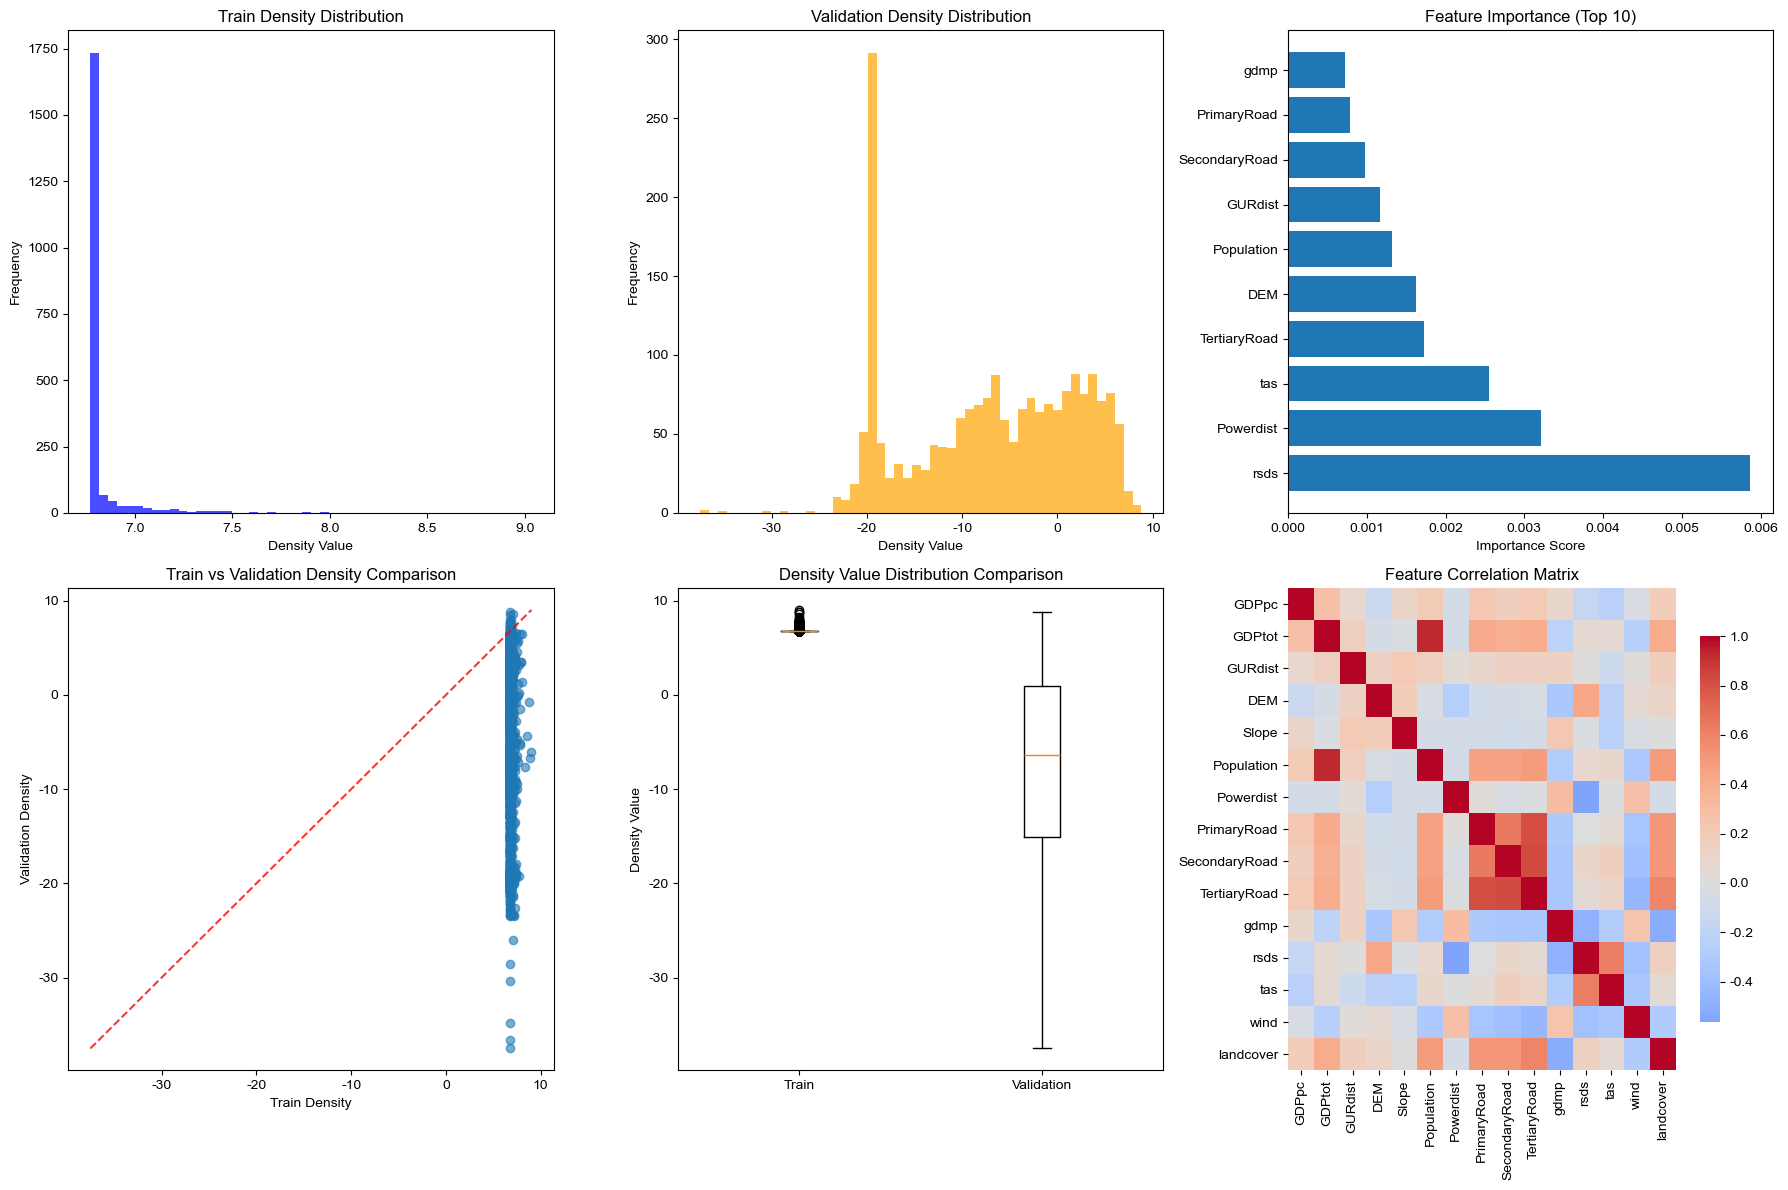

✅ Diagnostic plots generated successfully

7. Overall Evaluation and Suggestions
--------------------------------------------------
Model diagnosis summary:
- Data size: 8121 train samples, 2031 validation samples
- Number of features: 15
- Best bandwidth: 0.200923
- Overfitting degree: Low
阶段一完成！

6. 阶段二：深度学习分类器训练
--------------------------------------------------

使用固定负样本比例 0.3 进行训练...
Enhanced KDE + Deep Learning Hybrid Pipeline
Hybrid KDE + Deep Learning Pipeline
Extracting negative samples from df_abandon (sacrificing some data for generalization)
1. Calculating KDE environmental similarity for all abandoned land...
Number of positive samples: 10152
Target number of negative samples: 3045
Negative sample ratio: 0.3

Dataset split:
  Positive samples: 10152 (PV deployment data)
  Negative samples: 3045 (lowest KDE scoring abandoned land)
  Total training set: 13197
  Positive:Negative ratio: 1:0.30

Prediction data:
  Remaining abandoned land: 61937 (for final prediction)
  Sacrifi

计算距离矩阵: 100%|██████████| 65/65 [00:06<00:00, 10.68it/s]


✅ 向量化匹配完成！
  未训练样本: 62,193
  已训练样本: 2,789
总撂荒地样本: 64,982
参与训练的样本: 2,789
未参与训练的样本: 62,193

🔍 Debug - 数据验证:
  y_test shape: (2640,)
  y_test unique values: [0 1]
  y_pred_test_only shape: (2640, 1)
  y_pred_test_only unique values: [0 1]
  y_test sum: 2031
  y_pred_test_only sum: 2023
  y_test == 1 的数量: 2031
  y_pred_test_only == 1 的数量: 2023

�� Debug - 布尔运算验证:
  y_test == 1 的形状: (2640,)
  y_pred_test_only == 1 的形状: (2640, 1)
  (y_test == 1) & (y_pred_test_only == 1) 的形状: (2640, 2640)
  (y_test == 1) & (y_pred_test_only == 1) 的sum: 4108713
  y_pred_test_only_flat shape: (2640,)

Comprehensive Performance Summary
Training Set Performance:
  Accuracy: 0.9826
  AUC: 0.9969

PU Learning Metrics:
  Modified F1 Score: 1.2705
  Recall: 0.9867
  Detection Prevalence: 0.7663

KDE-Adjusted Metrics:
  传统Precision: 0.9906
  修正Precision: 0.0764
  传统F1: 0.9887
  修正F1: 0.1419

Data Validation:
  测试集样本数: 2,640
  测试集预测概率形状: (2640, 1)
  全部撂荒地样本数: 64,982
  全部撂荒地预测概率形状: (64982, 1)

Detailed Analysis:
  测试集真

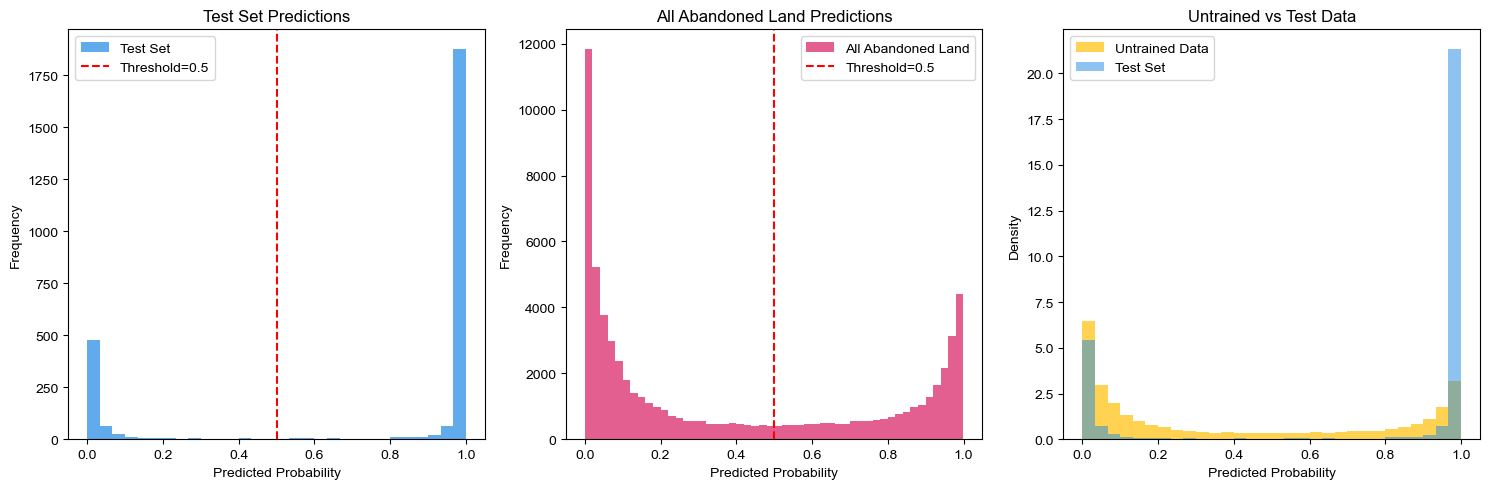

Result Evaluation and Visualization


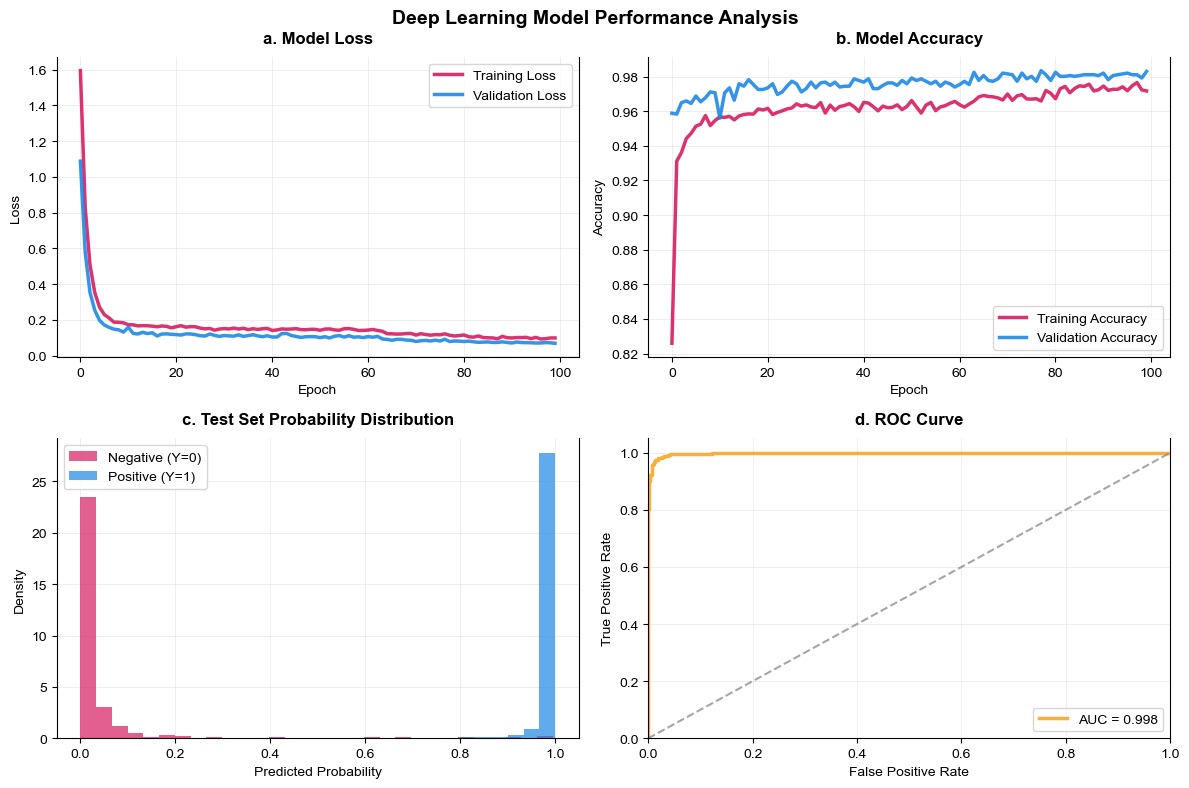


Generating learning curves...
Generating Learning Curves


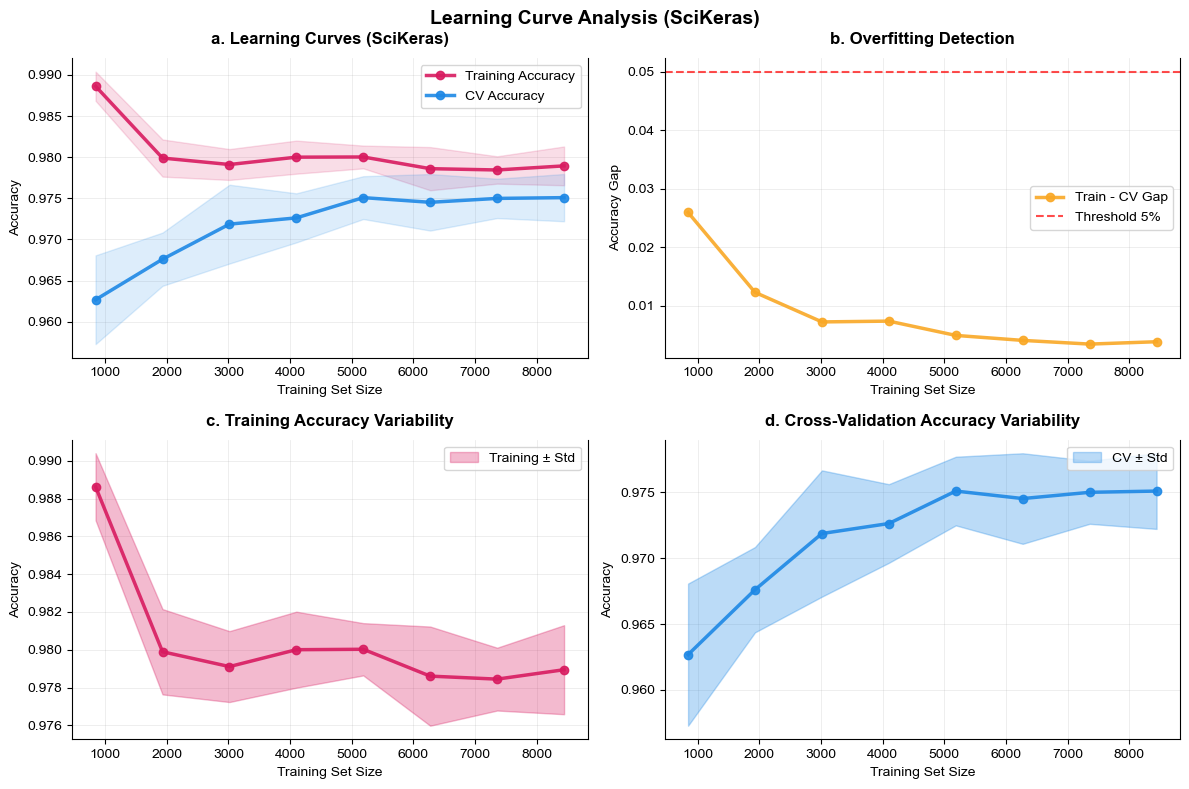


Learning Curve Analysis (SciKeras):
Final training accuracy: 0.9789
Final CV accuracy      : 0.9751
Final accuracy gap     : 0.0039
✅  No obvious overfitting.

Performing SHAP analysis...
GPU-Accelerated SHAP Analysis (TensorFlow)
❌ No GPU devices found, falling back to CPU
CPU Fallback SHAP Analysis
Computing SHAP values on CPU...


  0%|          | 0/2640 [00:00<?, ?it/s]

In [ ]:
from function import *
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

def main():
    """
    主函数：KDE + 深度学习混合方案完整流程
    """
    print("=" * 80)
    print("KDE + 深度学习混合方案 - 主程序")
    print("=" * 80)
    
    # ==============================
    # 1. 数据加载和预处理
    # ==============================
    print("\n1. 数据加载和预处理")
    print("-" * 50)
    
    # 美国本土边界定义
    usa_bounds_main = {
        'lon_min': -125,  # 美国本土最西端（华盛顿州）
        'lon_max': -65,   # 美国本土最东端（缅因州）
        'lat_min': 25,    # 美国本土最南端（佛罗里达州）
        'lat_max': 49     # 美国本土最北端（与加拿大接壤）
    }

    # 加载美国州界数据
    us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')
       
    # 加载核心数据
    print("加载数据...")
    df_abandon = load_abandon(PATHS['us_abandon'])
    df_embedding = load_embedding(PATHS['us_pv_embedding'])
    
    print(f"原始数据大小:")
    print(f"  df_abandon: {df_abandon.shape}")
    print(f"  df_embedding: {df_embedding.shape}")

    # ==============================
    # 2. 地理范围裁剪
    # ==============================
    print("\n2. 地理范围裁剪")
    print("-" * 50)
    
    # 第一次裁剪：使用边界框
    print("第一次裁剪：边界框裁剪...")
    df_embedding = df_embedding[
        (df_embedding['lon'] >= usa_bounds_main['lon_min']) & 
        (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
        (df_embedding['lat'] >= usa_bounds_main['lat_min']) & 
        (df_embedding['lat'] <= usa_bounds_main['lat_max'])
    ]

    # 第二次裁剪：使用州界形状文件进行精确裁剪
    def clip_data_with_us_states(df, lon_col='lon', lat_col='lat'):
        """
        使用美国州界形状文件裁剪数据
        """
        print(f"  裁剪数据: {df.shape} -> ", end="")
        
        # 从坐标创建几何点
        geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
        
        # 创建GeoDataFrame
        gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
        
        # 确保美国州界数据具有相同的CRS
        us_states_4326 = us_states.to_crs('EPSG:4326')
        
        # 执行空间连接，找到位于美国州界内的点
        clipped_gdf = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
        
        # 移除几何列，保留原始数据
        clipped_df = clipped_gdf.drop(columns=['geometry', 'index_right'])
        
        # 移除可能从形状文件添加的额外列
        shapefile_columns = us_states.columns.tolist()
        for col in shapefile_columns:
            if col in clipped_df.columns:
                clipped_df = clipped_df.drop(columns=[col])
        
        print(f"{clipped_df.shape}")
        return clipped_df

    print("第二次裁剪：州界精确裁剪...")
    df_abandon = clip_data_with_us_states(df_abandon)
    df_embedding = clip_data_with_us_states(df_embedding)

    # ==============================
    # 3. 数据清洗和预处理
    # ==============================
    print("\n3. 数据清洗和预处理")
    print("-" * 50)
    
    # 填充缺失值
    print("填充缺失值...")
    df_abandon_fill = fill_nonpositive_with_nearest(df_abandon)
    df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)
    
    # 去除重复值
    print("去除重复值...")
    df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)
    
    print(f"预处理后数据大小:")
    print(f"  df_abandon_filtered: {df_abandon_filtered.shape}")
    print(f"  df_embedding_fill: {df_embedding_fill.shape}")

    # ==============================
    # 4. 特征工程
    # ==============================
    print("\n4. 特征工程")
    print("-" * 50)
    
    # 定义特征列（排除坐标列）
    features_no_coords = [f for f in NUMERIC_FEATURES + CAT_COLS if f not in ['lat', 'lon']]
    print(f"特征数量: {len(features_no_coords)}")
    print(f"特征列表: {features_no_coords}")

    # ==============================
    # 5. 阶段一：KDE模型训练和诊断
    # ==============================
    print("\n5. 阶段一：KDE模型训练和诊断")
    print("-" * 50)
    
    print("训练KDE模型...")
    kde_pipe = select_and_train_kde(
        df_embedding_fill[features_no_coords], 
        bandwidths=np.logspace(-3, 3, 100)
    )
    
    print("进行KDE模型综合诊断...")
    diagnosis_results = comprehensive_model_diagnosis_fixed(
        df_embedding=df_embedding_fill,
        df_abandon=df_abandon_filtered,
        features_no_coords=features_no_coords,
        test_size=0.2,
        random_state=42
    )
    
    print("阶段一完成！")

    # ==============================
    # 6. 阶段二：深度学习分类器训练
    # ==============================
    print("\n6. 阶段二：深度学习分类器训练")
    print("-" * 50)
    
    # 直接用ratio=0.3进行训练和输出
    ratio = 0.3
    print(f"\n使用固定负样本比例 {ratio} 进行训练...")
    final_results = run_hybrid_kde_dl_pipeline_enhanced(
        df_embedding=df_embedding_fill,
        df_abandon=df_abandon_filtered,
        features_no_coords=features_no_coords,
        kde_pipe=kde_pipe,
        negative_ratio=ratio,
        test_size=0.2,
        epochs=100,
        random_state=42
    )

    if final_results is not None:
        # 修复：使用负样本加回后的完整输出
        final_df = final_results['final_output']['df_final_output'].copy()
        
        # 保存完整结果（包含负样本和预测结果）
        output_filename = f'output/final_pv_suitability_best_ratio_{ratio}.csv'
        final_df.to_csv(output_filename, index=False)
        
        print(f"\n🎯 模型训练完成！")
        print(f"负样本比例: {ratio}")
        print(f"最终输出样本数量: {len(final_df)}")
        print(f"  - 负样本 (Y=0): {len(final_results['final_output']['df_negative_full'])}")
        print(f"  - 模型预测: {len(final_results['final_output']['df_prediction_full'])}")
        print(f"结果已保存到: {output_filename}")
        
        # 显示概率分布统计
        print(f"\n概率分布统计:")
        print(f"  - 负样本概率 (固定为0.0): {len(final_df[final_df['pv_suitability_prob'] == 0.0])}")
        print(f"  - 预测概率 > 0.5: {len(final_df[final_df['pv_suitability_prob'] > 0.5])}")
        print(f"  - 预测概率 ≤ 0.5: {len(final_df[(final_df['pv_suitability_prob'] > 0.0) & (final_df['pv_suitability_prob'] <= 0.5)])}")
        print(f"  - 平均预测概率: {final_df[final_df['pv_suitability_prob'] > 0.0]['pv_suitability_prob'].mean():.4f}")
        
        # 保存详细结果
        detailed_results = {
            'best_ratio': ratio,
            'model_performance': final_results['performance'],
            'sacrifice_info': final_results['sacrifice_info'],
            'final_output_summary': {
                'total_samples': len(final_df),
                'negative_samples': len(final_results['final_output']['df_negative_full']),
                'predicted_samples': len(final_results['final_output']['df_prediction_full']),
                'mean_probability': final_df[final_df['pv_suitability_prob'] > 0.0]['pv_suitability_prob'].mean()
            }
        }
        
        # 保存详细结果到JSON文件
        import json
        with open(f'output/detailed_results_ratio_{ratio}.json', 'w') as f:
            json.dump(detailed_results, f, indent=2, default=str)
        
        print(f"详细结果已保存到: output/detailed_results_ratio_{ratio}.json")
        
    else:
        print("❌ 最终训练失败")
    


   

    # ==============================
    # 7. 额外分析：KDE评分分布
    # ==============================
    print("\n8. 额外分析：KDE评分分布")
    print("-" * 50)
    
    try:
        # 计算所有撂荒地的KDE评分
        print("计算所有撂荒地的KDE评分...")
        dens, env_scores = score_env(
            kde_pipe, 
            df_abandon_filtered[features_no_coords], 
            method='sigmoid', 
            sigmoid_alpha=0.5
        )
        
        # 可视化KDE评分分布
        plt.figure(figsize=(15, 5))
        
        # 原始密度分布
        plt.subplot(131)
        plt.hist(dens, bins=50, density=True)
        plt.yscale('log')
        plt.title('原始密度分布 (对数刻度)')
        plt.xlabel('密度值')
        plt.ylabel('频率 (对数)')
        
        # 归一化后的得分分布
        plt.subplot(132)
        plt.hist(env_scores, bins=50, density=True)
        plt.title('归一化得分分布')
        plt.xlabel('得分')
        plt.ylabel('频率')
        
        # 得分分布箱线图
        plt.subplot(133)
        plt.boxplot(env_scores)
        plt.title('KDE得分分布箱线图')
        plt.ylabel('得分')
        
        plt.tight_layout()
        plt.savefig('output/kde_score_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("KDE评分分布图已保存到: output/kde_score_distribution.png")
        
    except Exception as e:
        print(f"❌ KDE评分分布分析失败: {e}")

    print("\n" + "=" * 80)
    print("主程序执行完成！")
    print("=" * 80)

if __name__ == '__main__':
    main()

    
    
    

# 模型保存与输出

In [ ]:
df_embedding_fill[features_no_coords]
df_abandon_filtered[features_no_coords]

In [ ]:
# 将env_scores匹配到原始样本的经纬度上并保存
df_abandon_filtered['env_scores'] = env_scores
# Try saving with different encoding
df_abandon_filtered.to_csv('./data/abandon_filtered_with_scores.csv', index=False)# 绘制地图
plt.figure(figsize=(10,6))

# 绘制待预测点
plt.scatter(df_abandon_filtered['lon'], df_abandon_filtered['lat'], 
           c=df_abandon_filtered['env_scores'], cmap='viridis',
           alpha=0.5, label='Prediction Points')

# 叠加训练样本点
plt.scatter(df_embedding_fill['lon'], df_embedding_fill['lat'],
           color='red', alpha=0.5, s=20, label='Training Points')

plt.colorbar(label='Environmental Scores')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Distribution of Environmental Scores')
plt.legend()
plt.show()

In [ ]:
df_abandon